# Core Plotting Code;
## "What is the spatially resolved mass distribution of Enso-z5?"

This is the code I used to plot key data and results from my MPhil project, i.e.:
- 10 images from 10 different filters taken with JWST's NIRCam
- Results of morphological fitting with PySersic, first for 1 component fits to each image, then for the 4-component fits.
- Results of the stellar population analysis following SED-fitting with prospector (the modeling and results of which were done in linux/bash)
- Plotting mass maps combining these results (using morphological models to create mass/SFR surface density maps)
- Calculating radial mass profiles using these maps
- Plotting inferred radial dark matter fractions


In [ ]:
# Load in libraries & data, explore it.
# *(What is the data?)*

from astropy.io import fits 
import matplotlib.pyplot as plt
import numpy as np
# core libs for coords and scales:
from astropy.wcs import WCS
from astropy.nddata import Cutout2D
from astropy.coordinates import SkyCoord
import astropy.units as u
import matplotlib.patches as patches
import seaborn as sns

#from sedpy import observate
import os

# solves an error from our function that happens because of some distortion coefficient nonsense 
# between astropy and drizzled HST images. use to fix your header before running WCS(header).
def strip_SIP(header):
    A_prefixes = [i for i in header.keys() if i.startswith('A_')]
    B_prefixes = [i for i in header.keys() if i.startswith('B_')]
    for a,b in zip(A_prefixes,B_prefixes):
        del header[a]
        del header[b]
    return header

# fn to easily load fits files
def load_fits(fpath,extension=0):
    '''
    Function to load a FITs file into Python

    Parameters
    ----------
    fpath: str
        path to the FITS file to load. must end in .fit/.fits/.FIT/.FITS
    extension: int (optional)
        extension of the FITS file to load. (default 0)
    
    Returns
    -------
    header: dict_like
        the read in header of the chosen extension, as a python dictionary
    data: array_like
        the data contained in the extension, whether an image or table.
    '''
    with fits.open(fpath) as hdu:
        header = hdu[extension].header
        data = hdu[extension].data
    return header, data       

Defining, testing, loading-in data:

In [2]:
file_core = r"D:\Programming\Cambridge\Enso Data\191250_cutouts\191250_"
# define filter list
filter_list = ["F090W", "F115W", "F150W", "F182M", "F200W", "F210M", "F277W", "F356W", "F410M", "F444W"]

PSF_list = [0.033, 0.040, 0.050, 0.062, 0.066, 0.071, 0.092, 0.116, 0.137, 0.145]

# test_file = ftest
ftest = file_core + filter_list[9] + '.fits'
testPSF = PSF_list[7]
header, data = load_fits(ftest)

In [3]:
pixar_vals = []
pixar_scales = []
for i, name in enumerate(filter_list):
    with fits.open(file_core + name + '.fits') as hdul:
        pixel_area = hdul[0].header['PIXAR_A2']
        pixel_scale = np.sqrt(pixel_area)
        pixar_vals.append(pixel_area)
        pixar_scales.append(pixel_scale)
print(pixar_vals)

[0.000899684595650764, 0.000899684595650764, 0.000899684595650764, 0.000899684595650764, 0.000899684595650763, 0.000899684595650763, 0.000899684595650763, 0.000899684595650763, 0.000899684595650763, 0.000899684595650763]


In [4]:
# function to zoom in on the central 50x50 pixels of an image;
# needed to single out Enso in the cutouts
def zoomer(header, image_data):
    
    # fn to take header & image data and provide a zoom on central square
    # Map pixels to WCS coords
    wcs = WCS(header)
    wcs

    # singling out center of image (to focus on Enso)
    coords = wcs.array_index_to_world(100,100)
    RA = coords.ra.deg
    DEC =  coords.dec.deg
    galaxy_position = SkyCoord(ra=RA * u.deg, dec=DEC *u.deg)
    image_cutout = Cutout2D(image_data, galaxy_position, (50,50), wcs=wcs).data
    return image_cutout

Quick peek at SNRs to evaluate data reliability:

Set OBSGEO-B to    21.600401 from OBSGEO-[XYZ].
Set OBSGEO-H to 1234207865.831 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    21.600401 from OBSGEO-[XYZ].
Set OBSGEO-H to 1234207865.831 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    22.090597 from OBSGEO-[XYZ].
Set OBSGEO-H to 1234812278.786 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    22.090597 from OBSGEO-[XYZ].
Set OBSGEO-H to 1234812278.786 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    23.588408 from OBSGEO-[XYZ].
Set OBSGEO-H to 1237564059.407 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    23.588408 from OBSGEO-[XYZ].
Set OBSGEO-H to 1237564059.407 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    23.975280 from OBSGEO-[XYZ].
Set OBSGEO-H to 1503141563.916 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    23.975280 from OBSGEO-[XYZ].
Set OBSGEO-H to 1503141563.916 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    23.090550 from OBSGEO-[XYZ].
Set OBSGEO-H to 

Text(0, 0.5, 'Mean Signal to Noise')

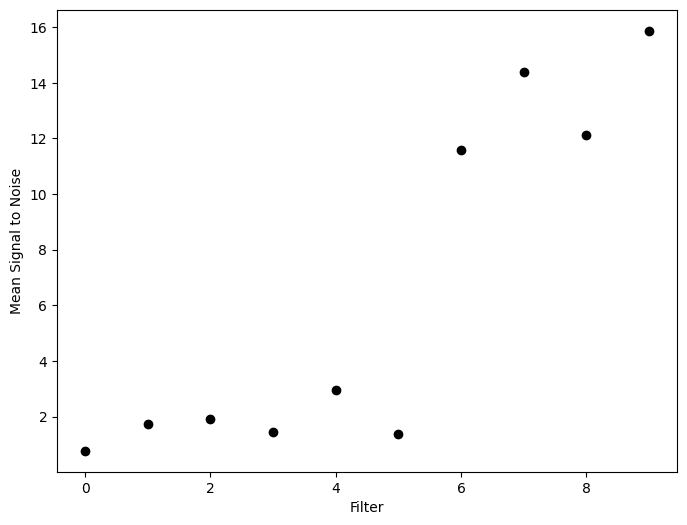

In [5]:
SNRs = []

for i, f in enumerate(filter_list):
        # load image data
        fname = (file_core + f + '.fits')
        with fits.open(fname) as hdul:
            image_data = hdul[1].data
            header = hdul[1].header
            noise = hdul[2].data
            
                    
        zoomed_im = zoomer(header, image_data)
        zoomed_noise = zoomer(header, noise)
        # calculate SNR
        sig_noise = zoomed_im / zoomed_noise   
        SNRs.append(sig_noise)
        mean_SNRs = [np.mean(i) for i in SNRs]
mean_SNRs

# plot mean SNR for each filter
plt.figure(figsize=(8, 6))
plt.plot(mean_SNRs, 'o', label='Mean Signal to Noise', color='black')
plt.xlabel("Filter")
plt.ylabel("Mean Signal to Noise")


In [6]:
load_fits(ftest, extension=1)

(XTENSION= 'IMAGE   '           / Image extension                                
 BITPIX  =                  -32 / array data type                                
 NAXIS   =                    2 / number of array dimensions                     
 NAXIS1  =                  200                                                  
 NAXIS2  =                  200                                                  
 PCOUNT  =                    0 / number of parameters                           
 GCOUNT  =                    1 / number of groups                               
 WCSAXES =                    2 / Number of coordinate axes                      
 CRPIX1  =              -2136.5 / Pixel coordinate of reference point            
 CRPIX2  =               3822.5 / Pixel coordinate of reference point            
 PC1_1   =                 -1.0 / Coordinate transformation matrix element       
 CDELT1  =  8.3318730000584E-06 / [deg] Coordinate increment at reference point  
 CDELT2  =  8.33

In [7]:
# Getting restframe wlengths:
from astropy.cosmology import Planck18 as cosmo
from sedpy import observate 
import asdf
filterlist = observate.load_filters(["jwst_" + f for f in filter_list])


redshift = 5.3
pix_scale = 0.02999474280021024
  # ??
kpc_per_arcsec = cosmo.kpc_proper_per_arcmin(redshift).value/60
wv_list = np.array([filterlist[:][ii].wave_effective/1e4 for ii in range(len(filter_list))])
rest_wvs = wv_list/(1+redshift)
print("Filter wavelengths: ", wv_list)
print("Rest wavelengths: ", rest_wvs)

Filter wavelengths:  [0.89824364 1.14859202 1.49442228 1.84236203 1.97811383 2.09374694
 2.76120868 3.54834844 4.07932817 4.37878307]
Rest wavelengths:  [0.14257836 0.18231619 0.23720989 0.29243842 0.31398632 0.33234078
 0.43828709 0.56322991 0.64751241 0.69504493]


In [8]:
# Map pixels to WCS coords
wcs = WCS(header)
wcs

Set OBSGEO-B to    23.044721 from OBSGEO-[XYZ].
Set OBSGEO-H to 1236397528.843 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : np.float64(53.122781107619) np.float64(-27.805160455556) 
CRPIX : np.float64(-2136.5) np.float64(3822.5) 
PC1_1 PC1_2  : np.float64(-1.0) np.float64(0.0) 
PC2_1 PC2_2  : np.float64(0.0) np.float64(1.0) 
CDELT : np.float64(8.3318730000584e-06) np.float64(8.3318730000584e-06) 
NAXIS : 200  200

### Plotting the image data: cutouts of Enso-z5 in 10 wavelengths

In [9]:
# singling out center of image (to focus on Enso)
coords = wcs.array_index_to_world(100,100)
RA = coords.ra.deg
DEC =  coords.dec.deg
galaxy_position = SkyCoord(ra=RA * u.deg, dec=DEC *u.deg)


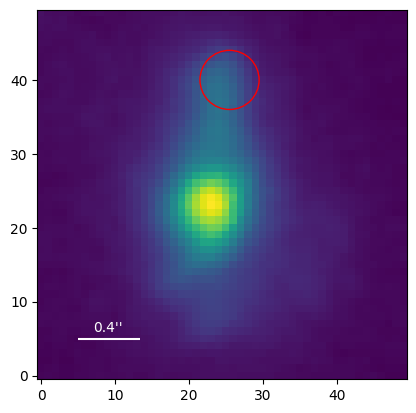

In [10]:
# cutting out around Enso with a scalebar
image_cutout = Cutout2D(image_data, galaxy_position, (50,50), wcs=wcs).data
plt.imshow(image_cutout, origin='lower')

# scalebar creation
n_pix_arcsec = 1 / pixel_scale
n_pix_arcsec
# multiply this guy by the width of the PSF; i.e. n_pix_arcsec * PSF FWHM Arcsec
PSF_radius = (n_pix_arcsec * testPSF)/2 # pixels per arcsecond, multiplied by the PSF in arcseconds, gives the width/radius of PSF in pixels

plt.hlines(5,5, (n_pix_arcsec *0.4), color='white')
plt.text(7,6, "0.4''", color='white')

circle = patches.Circle((25.5, 40), radius=4, edgecolor='red', facecolor='none', lw=1)
plt.gca().add_patch(circle)

plt.show()

In [11]:
# COLORBAR SORCERY (to set cbar height within axes, not image height)
from mpl_toolkits import axes_grid1

def add_colorbar(im, aspect=20, pad_fraction=0.5, **kwargs):
    """Add a vertical color bar to an image plot."""
    divider = axes_grid1.make_axes_locatable(im.axes)
    width = axes_grid1.axes_size.AxesY(im.axes, aspect=1./aspect)
    pad = axes_grid1.axes_size.Fraction(pad_fraction, width)
    current_ax = plt.gca()
    cax = divider.append_axes("right", size=width, pad=pad)
    plt.sca(current_ax)
    return im.axes.figure.colorbar(im, cax=cax, **kwargs)

Set OBSGEO-B to    23.044721 from OBSGEO-[XYZ].
Set OBSGEO-H to 1236397528.843 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


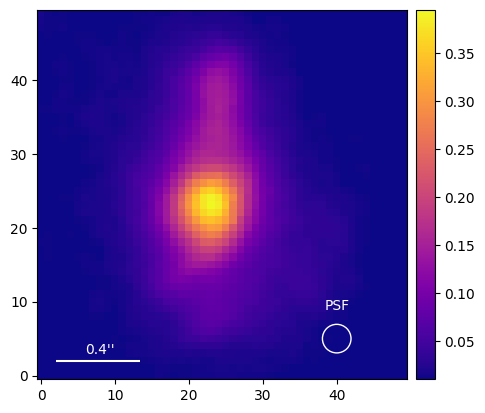

In [12]:

# function to add an arcsecond scalebar to a plot
def arcscalebar(arcscale, color):
    # scalebar creation
    plt.hlines(2,2, (n_pix_arcsec *arcscale), color=color)
    plt.text(6,3, "0.4''", color='white')
    return

zoomed = zoomer(header, image_data)

x_center, y_center = 40, 5  # Example coordinates for the center of the circle
# Create a Circle patch
circle = patches.Circle((x_center, y_center), radius=PSF_radius, edgecolor='white', facecolor='none', lw=1)
# Add the circle to the plot
fig, ax = plt.subplots()
add_colorbar(ax.imshow(zoomed, cmap='plasma', origin='lower', vmin=0.01))
ax.add_patch(circle)
# Step 4: Add a small title "PSF" above the circle
plt.text(x_center, y_center + PSF_radius + 2, 'PSF', color='white', ha='center', fontsize=10)

plt.imshow(zoomed, cmap='plasma', origin='lower', vmin=0.01)
arcscalebar(0.4,'white')

## SFR/Mass, FRESCO
Creating a comparative plot of Enso's SFR and Mass against a FRESCO survey sample

<>:4: SyntaxWarning: invalid escape sequence '\P'
<>:4: SyntaxWarning: invalid escape sequence '\P'
C:\Users\kings\AppData\Local\Temp\ipykernel_20880\1705398558.py:4: SyntaxWarning: invalid escape sequence '\P'
  catalog = Table.read('D:\Programming\Cambridge\Enso Data\Gold_Silver_Unres_FRESCO_CONGRESS.txt', format='ascii')


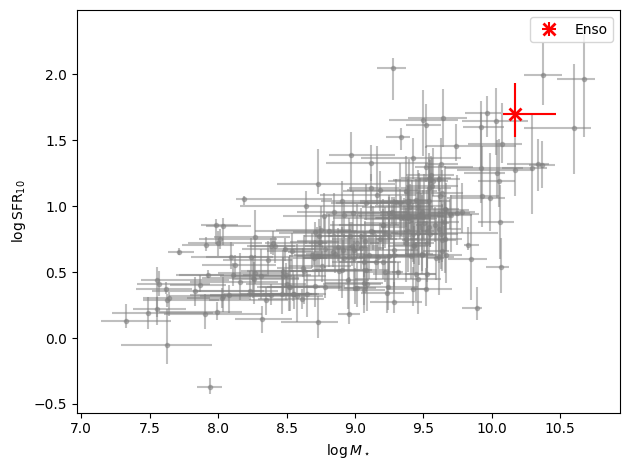

In [14]:
from astropy.table import Table

# Load data
catalog = Table.read('D:\Programming\Cambridge\Enso Data\Gold_Silver_Unres_FRESCO_CONGRESS.txt', format='ascii')

# Extract values for SFR10
mstar = catalog['logmstar']
mstar_err_low = catalog['logmstar_elow']
mstar_err_high = catalog['logmstar_ehigh']

sfr = catalog['logSFR10']
sfr_err_low = catalog['logSFR10_elow']
sfr_err_high = catalog['logSFR10_ehigh']

# Plot all galaxies
plt.errorbar(mstar, sfr, 
             xerr=[mstar_err_low, mstar_err_high], 
             yerr=[sfr_err_low, sfr_err_high],
             fmt='o', ms=3, alpha=0.5, color='gray')

# Highlight your galaxy
gal = catalog[catalog['ID'] == 191250][0]
plt.errorbar(gal['logmstar'], gal['logSFR10'],
             xerr=[[gal['logmstar_elow']], [gal['logmstar_ehigh']]],
             yerr=[[gal['logSFR10_elow']], [gal['logSFR10_ehigh']]],
             fmt='x', ms=8, color='red', mew=2, label='Enso')

plt.xlabel(r'$\log M_\star$')
plt.ylabel(r'$\log \mathrm{SFR}_{10}$')
plt.legend()
plt.tight_layout()
plt.show()


Adding legend & labels:

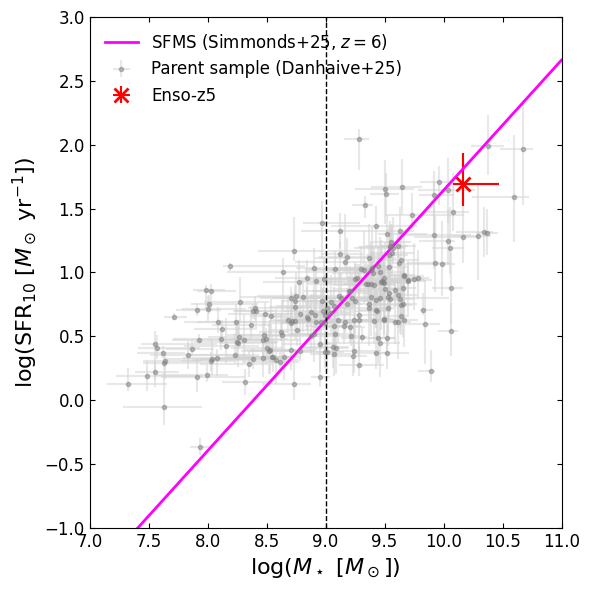

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table

# Load data
# catalog = Table.read('Gold_Silver_Unres_FRESCO_CONGRESS.txt', format='ascii')

# Extract SFR10 and errors
mstar = catalog['logmstar']
mstar_err_low = catalog['logmstar_elow']
mstar_err_high = catalog['logmstar_ehigh']

sfr = catalog['logSFR10']
sfr_err_low = catalog['logSFR10_elow']
sfr_err_high = catalog['logSFR10_ehigh']

plt.figure(figsize=(6, 6))
# Plot all galaxies
plt.errorbar(mstar, sfr, 
             xerr=[mstar_err_low, mstar_err_high], 
             yerr=[sfr_err_low, sfr_err_high],
             fmt='o', ms=3, alpha=0.5, color='gray', ecolor='lightgray', label='Parent sample (Danhaive+25)')

# Highlight your galaxy
gal = catalog[catalog['ID'] == 191250][0]
plt.errorbar(gal['logmstar'], gal['logSFR10'],
             xerr=[[gal['logmstar_elow']], [gal['logmstar_ehigh']]],
             yerr=[[gal['logSFR10_elow']], [gal['logSFR10_ehigh']]],
             fmt='x', ms=10, color='red', mew=2, label='Enso-z5')

# ----- SFMS from Simmonds+25 -----
s_b = 0.05   # Gyr^-1
beta = 0.02
mu = 2.30
z = 6.0     # or your exact redshift

logM = np.linspace(7, 11, 200)
M = 10**logM
log_sSFR_MS_Gyr = np.log10(s_b) + beta*(logM - 10) + mu*np.log10(1+z)
logSFR_MS = logM + log_sSFR_MS_Gyr - 9  # convert Gyr^-1 to yr^-1

plt.plot(logM, logSFR_MS, lw=2, color='magenta', label='SFMS (Simmonds+25, $z = 6$)')

# Formatting
plt.axvline(9, color='k', linestyle='--', linewidth=1)
plt.xlabel(r'$\log(M_\star\ [M_\odot])$', fontsize=16)
plt.ylabel(r'$\log(\mathrm{SFR}_{10}\ [M_\odot\ \mathrm{yr}^{-1}])$', fontsize=16)
plt.tick_params(axis='both', which='both', direction='in', top=True, right=True, labelsize=12)
plt.xlim(7, 11)
plt.ylim(-1, 3)
plt.legend(frameon=False, fontsize=12, loc='upper left')
plt.tight_layout()
plt.savefig('galsample.pdf', dpi=300, bbox_inches='tight')
plt.show()


RGB Image
========
Plotting an RGB composite using a combination of 3 images (out of the 10 available)

In [16]:
import matplotlib.pyplot as plt
from astropy.visualization import make_lupton_rgb
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename

# want filter_list 2, 6, 9

rgb_list = ["F150W", "F210M", "F356W"]

g_name = (file_core + rgb_list[0] + '.fits')
r_name = (file_core + rgb_list[1] + '.fits')
i_name = (file_core + rgb_list[2] + '.fits')

with fits.open(g_name) as hdul:
    g = image_data = hdul[1].data
    header = hdul[1].header
    # g = zoomer(header,image_data)
with fits.open(r_name) as hdul:
    r = image_data = hdul[1].data
    header = hdul[1].header
    # r = zoomer(header,image_data)
with fits.open(i_name) as hdul:
    i = image_data = hdul[1].data
    header = hdul[1].header
    # i = zoomer(header,image_data)

In [17]:
import numpy as np

print("Min:", np.min(i))
print("Max:", np.max(i))
print("Mean:", np.mean(i))
print("Std:", np.std(i))

Min: -0.0059169615
Max: 2.792538
Mean: 0.0073335334
Std: 0.070502184


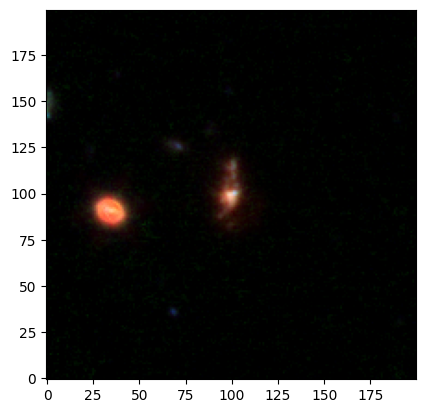

In [18]:

rgb_default = make_lupton_rgb(i, r, g, minimum=0.002, stretch=0.3, Q=1)
plt.imshow(rgb_default, origin='lower')

Set OBSGEO-B to    23.588408 from OBSGEO-[XYZ].
Set OBSGEO-H to 1237564059.407 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    21.445878 from OBSGEO-[XYZ].
Set OBSGEO-H to 1541791521.761 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    22.225686 from OBSGEO-[XYZ].
Set OBSGEO-H to 1235003121.785 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


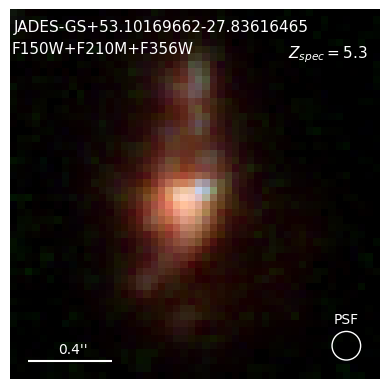

In [22]:
rgb_list = ["F150W", "F210M", "F356W"]

g_name = (file_core + rgb_list[0] + '.fits')
r_name = (file_core + rgb_list[1] + '.fits')
i_name = (file_core + rgb_list[2] + '.fits')

with fits.open(g_name) as hdul:
    image_data = hdul[1].data
    header = hdul[1].header
    g = zoomer(header,image_data)
with fits.open(r_name) as hdul:
    image_data = hdul[1].data
    header = hdul[1].header
    r = zoomer(header,image_data)
with fits.open(i_name) as hdul:
    image_data = hdul[1].data
    header = hdul[1].header
    i = zoomer(header,image_data)
    
rgb_default = make_lupton_rgb(i, r, g, minimum=0.002, stretch=0.3, Q=1)
# plt.imshow(rgb_default, origin='lower')


x_center, y_center = 45, 4  # Example coordinates for the center of the circle
# Create a Circle patch
circle = patches.Circle((x_center, y_center), radius=PSF_radius, edgecolor='white', facecolor='none', lw=1)
# Add the circle to the plot
fig, ax = plt.subplots()
# add_colorbar(ax.imshow(rgb_default, origin='lower'))
ax.add_patch(circle)
ax.set_axis_off()
# Step 4: Add a small title "PSF" above the circle
plt.text(x_center, y_center+3, 'PSF', color='white', ha='center', fontsize=10)

# Add info text
plt.text(20, 46.5, 'JADES-GS+53.10169662-27.83616465', color='white', ha='center', fontsize=11)
plt.text(12, 43.5, 'F150W+F210M+F356W', color='white', ha='center', fontsize=11)
plt.text(42.5, 43, r'$Z_{spec}=5.3$', color='white', ha='center', fontsize=11)


plt.imshow(rgb_default, origin='lower')
# plt.imshow(zoomed, cmap='plasma', origin='lower', vmin=0.01)

arcscalebar(0.4,'white')
plt.savefig('Enso_RGB.pdf', bbox_inches='tight')
# help(plt.savefig)


In [20]:
print("1st percentile:", np.percentile(zoomed, 1))
print("99th percentile:", np.percentile(zoomed, 99))
print("0.1 percentile:", np.percentile(zoomed, 0.1))
print("99.9 percentile:", np.percentile(zoomed, 99.9))

1st percentile: 0.0007353356
99th percentile: 0.30664963
0.1 percentile: -0.00051252695
99.9 percentile: 0.38135073


### Plotting all 10 filter images for comparison

Set OBSGEO-B to    21.600401 from OBSGEO-[XYZ].
Set OBSGEO-H to 1234207865.831 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    22.090597 from OBSGEO-[XYZ].
Set OBSGEO-H to 1234812278.786 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    23.588408 from OBSGEO-[XYZ].
Set OBSGEO-H to 1237564059.407 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    23.975280 from OBSGEO-[XYZ].
Set OBSGEO-H to 1503141563.916 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    23.090550 from OBSGEO-[XYZ].
Set OBSGEO-H to 1236488117.978 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    21.445878 from OBSGEO-[XYZ].
Set OBSGEO-H to 1541791521.761 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    22.046898 from OBSGEO-[XYZ].
Set OBSGEO-H to 1234752813.098 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    22.225686 from OBSGEO-[XYZ].
Set OBSGEO-H to 1235003121.785 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    23.166459 from OBSGEO-[XYZ].
Set OBSGEO-H to 

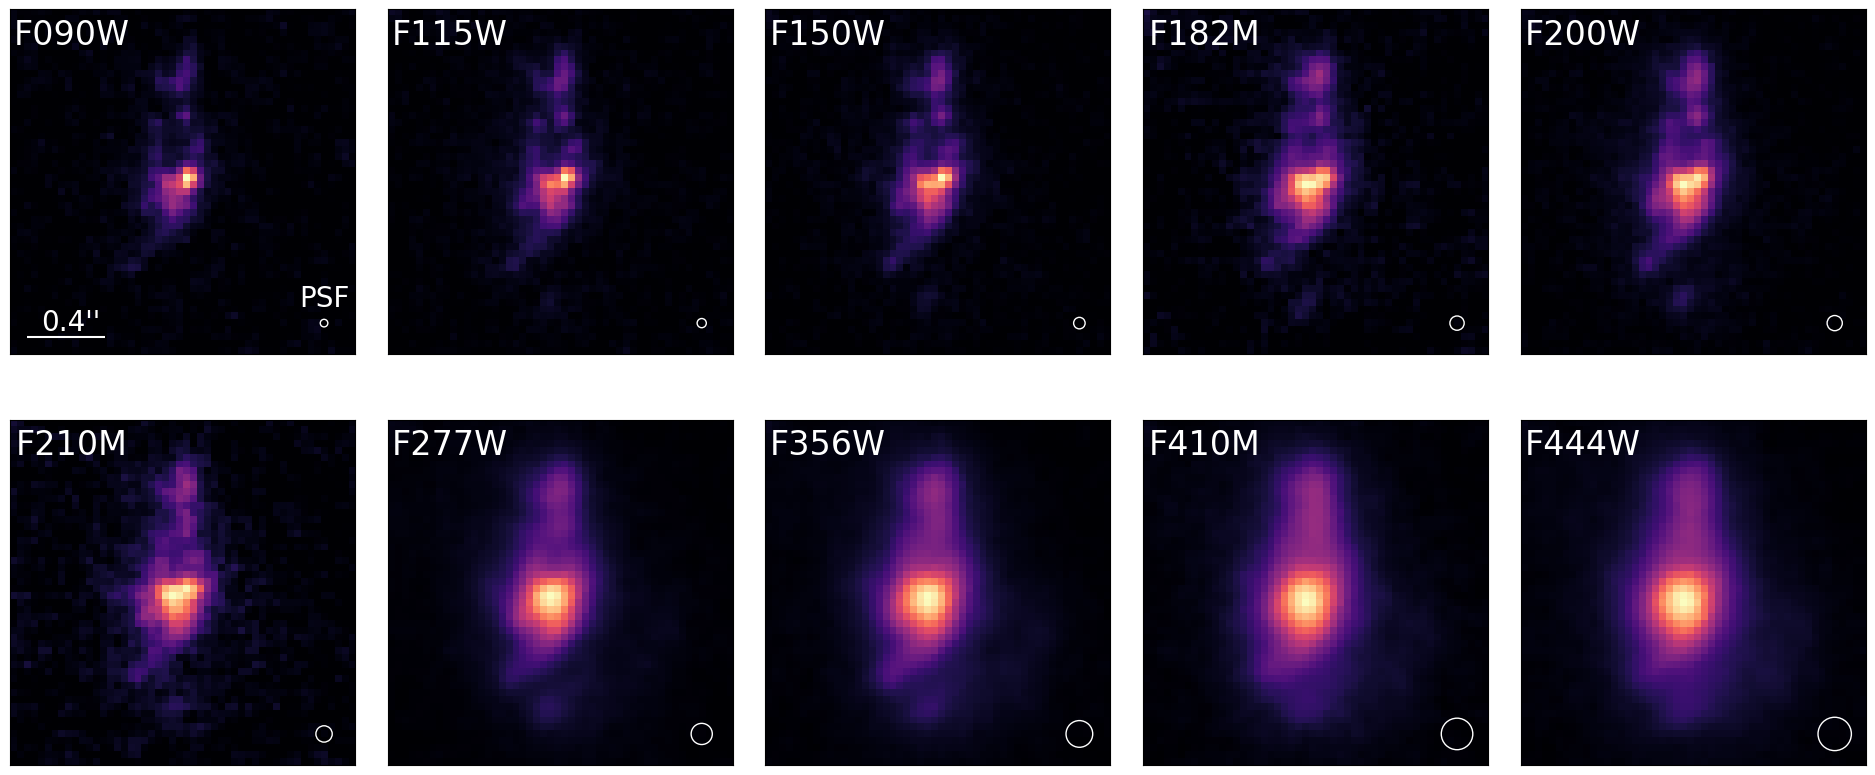

In [ ]:
from astropy.visualization import simple_norm

def FITS_plotter(filters, h=2, w=5, cmap='magma'):
    fig, axes = plt.subplots(h, w, figsize=(20, 10))
    plt.subplots_adjust(hspace=0.15)
    #plt.suptitle("Enso-z5", fontsize=18, y=0.95)
    
    for i, f in enumerate(filters):
        ax = axes.flat[i]
        # load image data
        fname = (file_core + f + '.fits')
        with fits.open(fname) as hdul:
            image_data = hdul[1].data
            header = hdul[1].header
        
        filter_PSF = PSF_list[i]   
        zoomed = zoomer(header, image_data)

        mu = np.mean(image_data)
        s = np.std(image_data)
        scale = 2
        # dvmin = mu - scale*s
        # dvmax = mu + scale*s
        norm = simple_norm(image_data, 'asinh', percent=99.8)
        vmin, vmax = np.percentile(image_data, (0.03, 99))
        # norm = simple_norm(zoomed, 'asinh', min_cut=0.00006, max_cut=0.3239)

        im = ax.imshow(zoomed, origin='lower', cmap=cmap, norm='asinh', vmin=0.0001)
        # ax.set_title(f'{filters[i]}'.upper())
        PSF_radius = (n_pix_arcsec * filter_PSF)/2
        x_center, y_center = 45, 4        # Create a Circle patch
        circle = patches.Circle((x_center, y_center), radius=PSF_radius, edgecolor='white', facecolor='none', lw=1)
        ax.add_patch(circle)
        ax.text(8.5, 44.5, f'{filters[i]}'.upper(), color='white', ha='center', fontsize=24)


        # Remove x and y axis values
        ax.set_xticks([])
        ax.set_yticks([])

    # add psf text
    axes[0][0].text(x_center, y_center + PSF_radius, 'PSF', color='white', ha='center', fontsize=20)


    # # Add a single colorbar for the entire figure
    # cbar = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.95)
    axes[0][0].hlines(2,2, (n_pix_arcsec *0.4), color='white')
    axes[0][0].text(4,3, "0.4''", color='white', fontsize=20)
    # add_colorbar(im)
    # arcscalebar(0.4,'white')

    fig.subplots_adjust(right=0.83)
    # cbar_ax = fig.add_axes([0.96, 0.087, 0.013, 0.77])
    # fig.colorbar(im, cax=cbar_ax)
    plt.tight_layout(rect=[0, 0, 0.95, 0.95])  
    # plt.savefig('enso_magma.pdf', dpi=300, bbox_inches='tight')
    plt.show()

FITS_plotter(filter_list, cmap='magma')


Single Sersic Fits as a fn of Wavelength
=======================================
Plotting the results of the single Sersic profile fits with PySersic

In [24]:
import asdf
from sedpy import observate

In [ ]:
# load in the data (as asdf)

path_wdir = f'D:\\Programming\\Cambridge\\Enso Data'

file_path = os.path.join(path_wdir, 'Output', f'fit_{filter_list[5]}.asdf')

filter_list = ["f090w", "f115w", "f150w", "f182m", "f200w", "f210m", "f277w", "f356w", "f410m", "f444w"]
filterlist = observate.load_filters(["jwst_" + f for f in filter_list])

af = asdf.open(file_path)

af.info()
r_eff = af["posterior"]['r_eff']


# r_eff_quantiles = 
params_single = list(af['posterior'].keys())

#for example, 16ht percentile for the first parameter 
param_a = params_single[3]
param_a_16 = np.percentile(np.concatenate(af['posterior'][param_a][:]), 16)
param_a_84 = np.percentile(np.concatenate(af['posterior'][param_a][:]), 84)

print(param_a_16, param_a_84)


root (AsdfObject)
├─asdf_library (Software)
│ ├─author (str): The ASDF Developers
│ ├─homepage (str): http://github.com/asdf-format/asdf
│ ├─name (str): asdf
│ └─version (str): 3.5.0
├─history (dict)
│ └─extensions (list) ...
├─input_data (dict)
│ ├─image (NDArrayType): shape=(50, 50), dtype=float32
│ ├─mask (NDArrayType): shape=(50, 50), dtype=bool
│ ├─psf (NDArrayType): shape=(37, 37), dtype=float32
│ └─rms (NDArrayType): shape=(50, 50), dtype=float32
├─loss_func (str): <function student_t_loss_free_sys at 0x000001FA74E2BE20>
├─method_used (str): sampling
├─posterior (dict)
│ ├─ellip (NDArrayType): shape=(2, 1000), dtype=float32
│ ├─flux (NDArrayType): shape=(2, 1000), dtype=float32
│ ├─n (NDArrayType): shape=(2, 1000), dtype=float32
│ ├─r_eff (NDArrayType): shape=(2, 1000), dtype=float32
│ └─4 not shown
├─prior_info (str)
└─rendere_type (str): <class 'pysersic.rendering.HybridRenderer'>
Some nodes not shown.
6.82264 7.4016056


In [28]:
# establishing conversions; pixel scale taken from .fits
pix_scale = 0.02999474280021024  
r_eff_asec = r_eff * pix_scale
r_eff_asec
r_eff_pc = 1/r_eff_asec
r_eff_asec

redshift = 5.3
kpc_per_arcsec = cosmo.kpc_proper_per_arcmin(redshift).value/60

r_eff_asec*kpc_per_arcsec

array([[1.39248531, 1.34875195, 1.36104981, ..., 1.42094138, 1.41335541,
        1.30575104],
       [1.35776669, 1.3507662 , 1.39881968, ..., 1.26563591, 1.30775145,
        1.27618783]])

In [27]:
0.4 * kpc_per_arcsec

np.float64(2.4938681463532775)

### Single Comp $R_{eff}$ with Wlgth
Plotting the effective radii against wavelength (from PySersic)

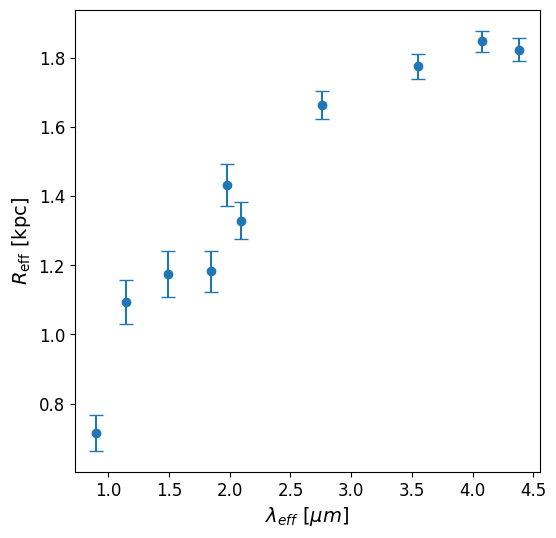

In [29]:
import asdf
from astropy.cosmology import Planck18 as cosmo 

# Define the path to the directory containing the ASDF files
path_wdir = f'D:\\Programming\\Cambridge\\Enso Data'

# load in effective wavelengths
wavelengths = []
for i in filterlist:
    wavelengths.append(i.wave_effective/10000)

# Initialize lists to store r_eff values and their errors
r_effs_kpc = []
r_eff_errors_lower = []
r_eff_errors_upper = []

# Loop through each filter, open the corresponding ASDF file, and extract r_eff
for filter_name in filter_list:
    file_path = os.path.join(path_wdir, 'Output', f'fit_{filter_name}.asdf')
    with asdf.open(file_path) as af:
        r_eff = af["posterior"]['r_eff'].mean()  # Adjust the key to match the structure of your ASDF file
        redshift = 5.3
        pixel_scale = 0.03  # taken from .fits value; arcsec/pixel
        kpc_per_arcsec = cosmo.kpc_proper_per_arcmin(redshift).value/60
        r_eff_asec = r_eff * pixel_scale
        r_eff_kpc = r_eff_asec*kpc_per_arcsec
        r_effs_kpc.append(r_eff_kpc)
        
        params_single = list(af['posterior'].keys())
        param_a = params_single[3]
        param_a_16 = (np.percentile(np.concatenate(af['posterior'][param_a][:]), 16)) * pixel_scale * kpc_per_arcsec
        param_a_84 = np.percentile(np.concatenate(af['posterior'][param_a][:]), 84) * pixel_scale * kpc_per_arcsec
        r_eff_errors_lower.append(r_eff_kpc - param_a_16)
        r_eff_errors_upper.append(param_a_84 - r_eff_kpc)


# Plot r_eff against wavelength
plt.figure(figsize=(6, 6))

# plt.rc('font', size=20)

plt.tick_params(axis='both', which='major', labelsize=12)
# plt.tick_params(axis='both', which='minor', labelsize=15)


plt.errorbar(wavelengths, r_effs_kpc, yerr=[r_eff_errors_lower, r_eff_errors_upper], fmt='o', capsize=5)
plt.xlabel(r"$\lambda_{eff}$ [$\mu m$]", fontsize=14)
plt.ylabel(r'$R_{\rm eff}$ [kpc]', fontsize =14)
# plt.title('Half-Light Radius vs Wavelength')
# plt.savefig('SingleReffWlgth.pdf', dpi=300, bbox_inches='tight')
plt.show()

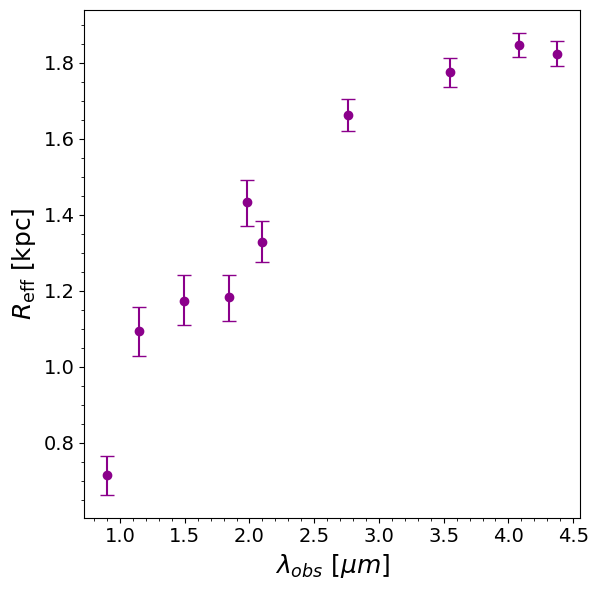

In [30]:
# Alternative styling code;

# Apply Seaborn style
# sns.set(style="white", font_scale=1.2)
plt.rcdefaults()
plt.style.use("default")
sns.reset_orig()
# Create color gradient from blue to red based on wavelength
# norm = plt.Normalize(min(wavelengths), max(wavelengths))
# cmap = plt.cm.managua_r
colors = 'darkmagenta'   #cmap(norm(wavelengths))

plt.figure(figsize=(6, 6))
plt.xlabel(r"$\lambda_{obs}$ [$\mu m$]", fontsize=18)
plt.ylabel(r'$R_{\rm eff}$ [kpc]', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.minorticks_on()

# Plot each point with error bars and color gradient
for i in range(len(wavelengths)):
    plt.errorbar(
        wavelengths[i], r_effs_kpc[i],
        yerr=[[r_eff_errors_lower[i]], [r_eff_errors_upper[i]]],
        fmt='o', capsize=5, color=colors
    )

plt.tight_layout()
# plt.savefig('SingleReffWlgth.pdf', dpi=300, bbox_inches='tight')
plt.show()


### Plotting Sersic profiles for each wavelength/image

In [31]:
# Need: amplitude (surface brightness @ r_eff)-- derived from the model
# effective radius, taken from asdf file - done above as r_effs_kpc, with r_eff_errors_lower and r_eff_errors_upper 
# Sersic index, taken from asdf file - done below for sersic_indices, with sersic_err_lower and sersic_err_upper

from astropy.modeling.models import Sersic1D

sersic_indices = []
sersic_err_lower = []
sersic_err_upper = []
fluxes = []
flux_lower = []
flux_upper = []

# call individual files to get sersic indices and Flux
for filter_name in filter_list:
    file_path = os.path.join(path_wdir, 'Output', f'fit_{filter_name}.asdf')
    with asdf.open(file_path) as af:
        sersic_index = af["posterior"]['n'].mean()
        sersic_indices.append(sersic_index)
        
        params_single = list(af['posterior'].keys())
        param_a = params_single[2]
        param_a_16 = (np.percentile(np.concatenate(af['posterior'][param_a][:]), 16))
        param_a_84 = np.percentile(np.concatenate(af['posterior'][param_a][:]), 84)
        sersic_err_lower.append(sersic_index - param_a_16)
        sersic_err_upper.append(param_a_84 - sersic_index)

        flux = af["posterior"]['flux'].mean()
        fluxes.append(flux)
        
        param_a = params_single[1]
        param_a_16 = (np.percentile(np.concatenate(af['posterior'][param_a][:]), 16))
        param_a_84 = np.percentile(np.concatenate(af['posterior'][param_a][:]), 84)
        flux_lower.append(flux - param_a_16)
        flux_upper.append(param_a_84 - flux)

print(fluxes)
flux_upper


[np.float32(6.778375), np.float32(15.54213), np.float32(18.411415), np.float32(21.213081), np.float32(26.264414), np.float32(26.020372), np.float32(57.508354), np.float32(67.11072), np.float32(101.87639), np.float32(92.92808)]


[np.float32(0.42316818),
 np.float32(0.53625584),
 np.float32(0.6432266),
 np.float32(0.8058624),
 np.float32(0.9349899),
 np.float32(0.8882866),
 np.float32(0.9439697),
 np.float32(0.9373169),
 np.float32(1.2068481),
 np.float32(1.0948868)]

In [33]:
from scipy.special import gamma

# determining amplitude, I: R = r_eff, so I(r_eff) = I_e

amplitudes = []

for i in range(len(filter_list)):
    F = fluxes[i]
    r_eff = r_effs_kpc[i]
    n = sersic_indices[i]
    # Compute b_n
    b_n = 2 * n - 1/3 + 4 / (405 * n) + 46 / (25515 * n**2)

    # Calculate I_e
    I_e = (F * b_n**(2 * n)) / (2 * np.pi * r_eff**2 * n * np.exp(b_n) * gamma(2 * n))
    amplitudes.append(I_e)
    
    print(f"Surface brightness at r_eff (I_e) for {filter_list[i]}: {I_e}")

# # Compute b_n
# b_n = 2 * n - 1/3 + 4 / (405 * n) + 46 / (25515 * n**2)

# # Calculate I_e
# I_e = (F * b_n**(2 * n)) / (2 * np.pi * r_eff**2 * n * np.exp(b_n) * gamma(2 * n))

Surface brightness at r_eff (I_e) for f090w: 1.2430922208606423
Surface brightness at r_eff (I_e) for f115w: 1.041042830526683
Surface brightness at r_eff (I_e) for f150w: 1.1216739704012002
Surface brightness at r_eff (I_e) for f182m: 1.3665183119312259
Surface brightness at r_eff (I_e) for f200w: 1.1361334764315139
Surface brightness at r_eff (I_e) for f210m: 1.3236223777208433
Surface brightness at r_eff (I_e) for f277w: 1.5075585390960247
Surface brightness at r_eff (I_e) for f356w: 1.6321704348573545
Surface brightness at r_eff (I_e) for f410m: 2.3593038812532607
Surface brightness at r_eff (I_e) for f444w: 2.1417278826719413


C:\Users\kings\AppData\Local\Temp\ipykernel_20880\1455987977.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('managua_r')  # Choose a colormap


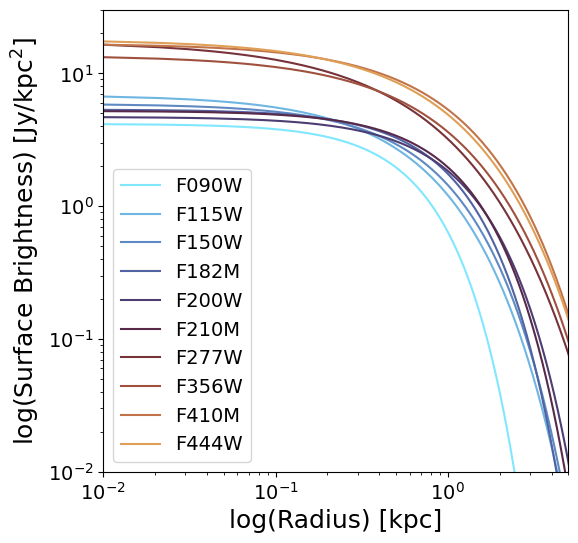

In [ ]:
import matplotlib.cm as cm

# plt.rcdefaults()
# plt.style.use("default")
# sns.reset_orig()

# Generate a range of radii (0 to 3*r_eff)
radii = np.linspace(0.01, 3 * max(r_effs_kpc), 500)

# Create sersic models to plot
sersic_models = []
brightnesses = []
for i in range(len(filter_list)):
    sersic_model = Sersic1D(amplitude=amplitudes[i], r_eff=r_effs_kpc[i], n=sersic_indices[i])
    sersic_models.append(sersic_model)
    
    # Evaluate the Sérsic profile
    brightness = sersic_model(radii)
    brightnesses.append(brightness)

# Sort the data based on sersic_indices
# sorted_indices = np.argsort(sersic_indices)
# filter_list = np.array(filter_list)[sorted_indices]
# amplitudes = np.array(amplitudes)[sorted_indices]
# r_effs_kpc = np.array(r_effs_kpc)[sorted_indices]
# sersic_indices = np.array(sersic_indices)[sorted_indices]


plt.figure(figsize=(6, 6))
cmap = cm.get_cmap('managua_r')  # Choose a colormap
min_index = np.argmin(r_effs_kpc)
max_index = np.argmax(r_effs_kpc)
plt.minorticks_on()
for i in range(len(filter_list)):
    color = cmap(i / len(filter_list))
    line, = plt.plot(radii, brightnesses[i], label=f"{filter_list[i]}".upper(), color=color)
    # if i == min_index:
    #     plt.axvline(r_effs_kpc[i], color=color, linestyle='--')
    #     plt.text(r_effs_kpc[i], max(brightnesses[i]), f"min r_eff", color=color, verticalalignment='bottom')
    # if i == max_index:
    #     plt.axvline(r_effs_kpc[i], color=color, linestyle='--')
    #     plt.text(r_effs_kpc[i], max(brightnesses[i]), f"max r_eff", color=color, verticalalignment='bottom')

# plt.axvline(r_eff, color='r', linestyle='--', label=r"$r_{\text{eff}}$")
plt.xscale('log')
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=14)
plt.xlim([1e-2, 5])
plt.ylim([1e-2, 30])
plt.xlabel("log(Radius) [kpc]", fontsize=18)
plt.ylabel("log(Surface Brightness) [Jy/kpc$^2$]", fontsize=18)
plt.legend(prop={'size':14})
# plt.grid()
# plt.savefig('brightnessprofiles.pdf', dpi=300, bbox_inches='tight')
plt.show()

### Comparative plot of flux against wavelength, for each of the 4 components

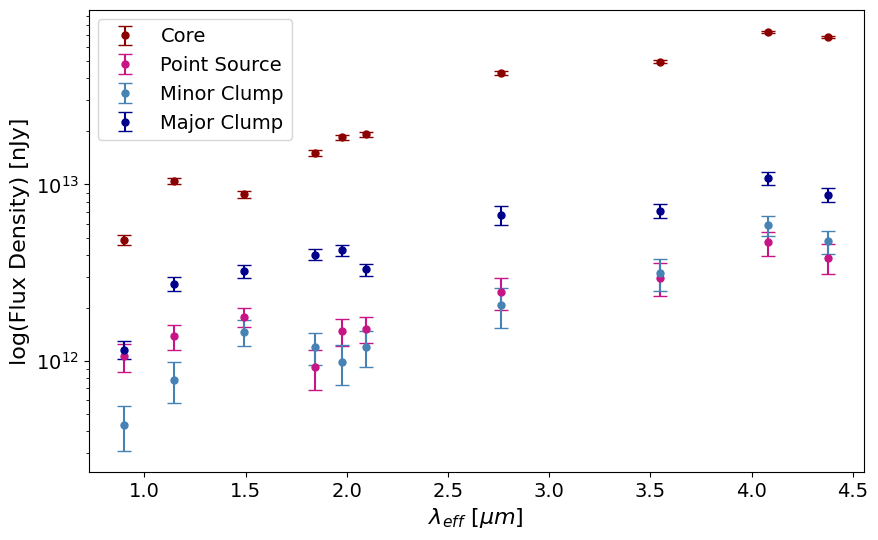

In [35]:
import asdf
from sedpy import observate
from astropy.cosmology import Planck18 as cosmo 

# Define the path to the directory containing the ASDF files
path_wdir = f'D:\\Programming\\Cambridge\\Enso Data'

filterlist = observate.load_filters(["jwst_" + f for f in filter_list])

wavelengths = []
for i in filterlist:
    wavelengths.append(i.wave_effective/10000)

flux_0s = []
flux_0s_errors_lower = []
flux_0s_errors_upper = []
flux_1s = []
flux_1s_errors_lower = []
flux_1s_errors_upper = []
flux_2s = []
flux_2s_errors_lower = []
flux_2s_errors_upper = []
flux_3s = []
flux_3s_errors_lower = []
flux_3s_errors_upper = []


for j, filter_name in enumerate(filter_list):
    file_path = os.path.join(path_wdir, 'Output', f'4compSVI_{filter_name}.asdf')
    with asdf.open(file_path) as af:
        params_single = list(af['posterior'].keys())
        # raw pysersic flux val of Jy/pixel^2
        flux_0 = af['posterior']['flux_0'].mean() * pixar_vals[j]
        flux_0s.append(flux_0)
        param_a_16 = np.percentile(np.concatenate(af['posterior']['flux_0'][:]), 16) * pixar_vals[j]
        param_a_84 = np.percentile(np.concatenate(af['posterior']['flux_0'][:]), 84) * pixar_vals[j]
        flux_0s_errors_lower.append(flux_0 - param_a_16)
        flux_0s_errors_upper.append(param_a_84 - flux_0)
        # print("low:", param_a_16)
        # print("flux:", flux_0s)
        # print("upper:", param_a_84)
        # print("calced low:", flux_0s_errors_lower)
        # print("calced upper:", flux_0s_errors_upper)

        flux_1 = af['posterior']['flux_1'].mean() * pixar_vals[j]
        flux_1s.append(flux_1)
        param_a_16 = np.percentile(np.concatenate(af['posterior']['flux_1'][:]), 16) * pixar_vals[j]
        param_a_84 = np.percentile(np.concatenate(af['posterior']['flux_1'][:]), 84) * pixar_vals[j]
        flux_1s_errors_lower.append(flux_1 - param_a_16)
        flux_1s_errors_upper.append(param_a_84 - flux_1)

        flux_2 = af['posterior']['flux_2'].mean() * pixar_vals[j]
        flux_2s.append(flux_2)
        param_a_16 = np.percentile(np.concatenate(af['posterior']['flux_2'][:]), 16) * pixar_vals[j]
        param_a_84 = np.percentile(np.concatenate(af['posterior']['flux_2'][:]), 84) * pixar_vals[j]
        flux_2s_errors_lower.append(flux_2 - param_a_16)
        flux_2s_errors_upper.append(param_a_84 - flux_2)

        flux_3 = af['posterior']['flux_3'].mean() * pixar_vals[j]
        flux_3s.append(flux_3)
        param_a_16 = np.percentile(np.concatenate(af['posterior']['flux_3'][:]), 16) * pixar_vals[j]
        param_a_84 = np.percentile(np.concatenate(af['posterior']['flux_3'][:]), 84) * pixar_vals[j]
        flux_3s_errors_lower.append(flux_3 - param_a_16)
        flux_3s_errors_upper.append(param_a_84 - flux_3)


# Convert fluxes to nJy

flux_0s = [val * 1e15 for val in flux_0s]
flux_0s_errors_lower = [err * 1e15 for err in flux_0s_errors_lower]
flux_0s_errors_upper = [err * 1e15 for err in flux_0s_errors_upper]

flux_1s = [val * 1e15 for val in flux_1s]
flux_1s_errors_lower = [err * 1e15 for err in flux_1s_errors_lower]
flux_1s_errors_upper = [err * 1e15 for err in flux_1s_errors_upper]

flux_2s = [val * 1e15 for val in flux_2s]
flux_2s_errors_lower = [err * 1e15 for err in flux_2s_errors_lower]
flux_2s_errors_upper = [err * 1e15 for err in flux_2s_errors_upper]

flux_3s = [val * 1e15 for val in flux_3s]
flux_3s_errors_lower = [err * 1e15 for err in flux_3s_errors_lower]
flux_3s_errors_upper = [err * 1e15 for err in flux_3s_errors_upper]

plt.rcdefaults()
plt.style.use("default")
sns.reset_orig()

# Plot flux against wavelength
plt.figure(figsize=(10, 6))

size = 5

# Ideal would be blue-to-red 
plt.errorbar(wavelengths, flux_0s, yerr=[flux_0s_errors_lower, flux_0s_errors_upper], markersize=size, fmt='o', capsize=5, label='Core', color='darkred')
plt.errorbar(wavelengths, flux_1s, yerr=[flux_1s_errors_lower, flux_1s_errors_upper], markersize=size, fmt='o', capsize=5, label='Point Source', color='mediumvioletred')
plt.errorbar(wavelengths, flux_2s, yerr=[flux_2s_errors_lower, flux_2s_errors_upper], markersize=size, fmt='o', capsize=5, label='Minor Clump', color='steelblue')
plt.errorbar(wavelengths, flux_3s, yerr=[flux_3s_errors_lower, flux_3s_errors_upper], markersize=size, fmt='o', capsize=5, label='Major Clump', color='darkblue')
# font = {'family' : 'DejaVu sans',
#         'weight' : 'normal',
#         'size'   : 15}
# plt.rc('font', **font)
# plt.plot(wavelengths, curve_of_best_fit, 'b-', label='Best Fit Line')
plt.xlabel(r"$\lambda_{eff}$ [$\mu m$]", fontsize=16)
plt.ylabel(r'log(Flux Density) [nJy]', fontsize=16)
plt.tick_params(axis='both', labelsize=14)
# plt.ylim(2e11, 1e14)
# plt.title('Half-Light Radius vs Wavelength')
plt.legend(fontsize=14)
plt.yscale('log')
# plt.savefig('4compFluxWlgth.pdf', bbox_inches='tight')
plt.show()

In [37]:
# checking specific flux values

import pandas as pd
# Convert Lists to DataFrame
# Use pandas to convert the lists into a DataFrame

# Create a dictionary with the lists
data = {
    'filter': filter_list,
    'wavelength': wavelengths,
    'flux_0s': flux_0s,
    'flux_0s_delta_lower': flux_0s_errors_lower,
    'flux_0s_delta_upper': flux_0s_errors_upper,
    'flux_1s': flux_1s,
    'flux_1s_delta_lower': flux_1s_errors_lower,
    'flux_1s_delta_upper': flux_1s_errors_upper,
    'flux_2s': flux_2s,
    'flux_2s_delta_lower': flux_2s_errors_lower,
    'flux_2s_delta_upper': flux_2s_errors_upper,
    'flux_3s': flux_3s,
    'flux_3s_delta_lower': flux_3s_errors_lower,
    'flux_3s_delta_upper': flux_3s_errors_upper
}

# Convert the dictionary to a DataFrame
df = pd.DataFrame(data)

# # Save the DataFrame to a CSV file
# df.to_csv('4compSVI_fluxes_nJy.csv', index=False)
# # df.iloc[:, 2:] /= 1e6
# # Display the DataFrame
df

,filter,wavelength,flux_0s,flux_0s_delta_lower,flux_0s_delta_upper,flux_1s,flux_1s_delta_lower,flux_1s_delta_upper,flux_2s,flux_2s_delta_lower,flux_2s_delta_upper,flux_3s,flux_3s_delta_lower,flux_3s_delta_upper
0,f090w,0.898244,4.865210e+12,3.079162e+11,2.989355e+11,1.061589e+12,1.993064e+11,1.867091e+11,4.317122e+11,1.220872e+11,1.221149e+11,1.160078e+12,1.334063e+11,1.317940e+11
1,f115w,1.148592,1.047377e+13,4.803976e+11,4.663859e+11,1.381498e+12,2.226577e+11,2.090139e+11,7.832367e+11,2.055244e+11,1.963993e+11,2.743968e+12,2.465004e+11,2.436538e+11
2,f150w,1.494422,8.810591e+12,3.777519e+11,3.667334e+11,1.773276e+12,2.084147e+11,2.111839e+11,1.467122e+12,2.558585e+11,2.483517e+11,3.228787e+12,2.623168e+11,2.611962e+11
3,f182m,1.842362,1.511291e+13,6.061876e+11,5.885083e+11,9.259985e+11,2.443190e+11,2.328773e+11,1.192380e+12,2.422429e+11,2.484407e+11,3.994000e+12,2.854013e+11,2.881130e+11
4,f200w,1.978114,1.847615e+13,6.311852e+11,6.127805e+11,1.478626e+12,2.636433e+11,2.483155e+11,9.794660e+11,2.522102e+11,2.462225e+11,4.243454e+12,2.953829e+11,3.008097e+11
5,f210m,2.093747,1.928073e+13,6.587766e+11,6.395653e+11,1.523230e+12,2.648631e+11,2.554650e+11,1.206020e+12,2.834385e+11,2.767433e+11,3.304171e+12,2.630122e+11,2.578543e+11
6,f277w,2.761209,4.283088e+13,1.239788e+12,1.203619e+12,2.462915e+12,5.079843e+11,5.011070e+11,2.066525e+12,5.363897e+11,5.364991e+11,6.717626e+12,8.356176e+11,8.215187e+11
7,f356w,3.548348,4.974933e+13,1.214746e+12,1.179315e+12,2.964142e+12,6.360484e+11,6.324376e+11,3.130277e+12,6.382288e+11,6.411979e+11,7.037253e+12,6.035250e+11,6.641499e+11
8,f410m,4.079328,7.309618e+13,1.288749e+12,1.251161e+12,4.692737e+12,7.417672e+11,7.088873e+11,5.894748e+12,7.794974e+11,7.712115e+11,1.083004e+13,9.469017e+11,9.622024e+11
9,f444w,4.378783,6.851446e+13,1.250818e+12,1.214325e+12,3.848450e+12,7.591971e+11,7.423612e+11,4.757425e+12,7.433560e+11,7.238812e+11,8.729975e+12,7.736291e+11,7.866555e+11


## Comparative Model Plots

- Need data, residual, and model DICTS for each filter

- 1st - load .fits IM data for each filter, then
- 2nd - Load (each) model-- .asdf "best_model_params" -> HybridRenderer?
- 3rd - Compute residuals for each model... image - model = residual

Here we plot side by side comparisons of the single sersic fits and the 4-component models, with their residuals and input images.

In [40]:
# (separate library loading to enable running this cell independently)

import os
import numpy as np 
from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt

from pysersic.results import plot_image
from pysersic import check_input_data
from pysersic.priors import SourceProperties
from pysersic.priors import autoprior
from pysersic import FitSingle
from pysersic.loss import student_t_loss_free_sys
from pysersic.results import plot_residual
from pysersic.rendering import HybridRenderer
# from pysersic.multiband import FitMultiBandPoly # "No module named 'pysersic.multiband'"

import jax
import jax.numpy as jnp
from jax.random import (
    PRNGKey,  # Need to use a seed to start jax's random number generation
)

import corner 

import asdf

import arviz as az

from sedpy import observate 

from astropy.modeling.models import Sersic1D
from astropy.cosmology import Planck18 as cosmo

In [41]:
path_wdir = f'D:\\Programming\\Cambridge\\Enso Data'

# self explanatory!

def load_data(filter, plot=False):

    '''
    Loading the data
    
    We'll be using three galaxies imaged by HSC for this example. The 4 needed inputs to perform a fit are
     - im: the image itself
     - mask: a mask indicating pixels which should not be included in the fit
     - sig: a map of pixel uncertainties 
     - psf: a map of the PSF (for now, only one psf can be used).
    '''

    # load image data
    fname = os.path.join(path_wdir, '191250_cutouts', '191250_' + filter.upper() + '.fits')
    im = fits.getdata(fname, 'SCI')
    wht = fits.getdata(fname, 'WHT')
    # can set sigma to ERR
    ycen, xcen = 100, 100
    im = im[xcen-22:xcen+28, ycen-25:ycen+25]
    wht = wht[xcen-22:xcen+28, ycen-25:ycen+25]
    mask = np.zeros(im.shape)
    sig = 0.01/np.sqrt(np.abs(wht)) + 0.1*np.sqrt(np.abs(im))
    sig = 0.1*np.sqrt(np.abs(im))
    header = fits.getheader(fname, 'SCI')
    
    # load the PSF data
    PSF_large = fits.getdata(os.path.join(path_wdir, 'mpsf_gds', 'mpsf_' + filter.lower() + '.fits'))
    cen = int(0.5*PSF_large.shape[0])
    psf = PSF_large[cen-18:cen+19, cen-18:cen+19]
    psf /= np.sum(psf)
    psf = psf.astype(float)

    if plot:
        # plot data
        fig, ax = plot_image(im, mask, sig, psf)
        plt.show()

    # check data
    if check_input_data(data=im, rms=sig, psf=psf, mask=mask):
        print("data looks good!")
    else:
        print("data looks bad!")

    return(im, mask, sig, psf)

# test on single filter
im, mask, sig, psf = load_data(filter='f090w')
from pysersic.results import plot_image

fig, ax = plot_image(im, mask, sig, psf)


data looks good!


data looks good!
data looks good!


C:\Users\kings\AppData\Local\Temp\ipykernel_20880\3721902705.py:30: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  single_models[key] = HybridRenderer(im.shape, jnp.array(af.tree['input_data']['psf'])).render_source(value, profile_type="sersic")
C:\Users\kings\AppData\Local\Temp\ipykernel_20880\3721902705.py:30: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  single_models[key] = HybridRenderer(im.shape, jnp.array(af.tree['input_data']['psf'])).render_source(value, profile_type="sersic")


data looks good!


C:\Users\kings\AppData\Local\Temp\ipykernel_20880\3721902705.py:30: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  single_models[key] = HybridRenderer(im.shape, jnp.array(af.tree['input_data']['psf'])).render_source(value, profile_type="sersic")
C:\Users\kings\AppData\Local\Temp\ipykernel_20880\3721902705.py:30: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  single_models[key] = HybridRenderer(im.shape, jnp.array(af.tree['input_data']['psf'])).render_source(value, profile_type="sersic")


data looks good!
data looks good!


C:\Users\kings\AppData\Local\Temp\ipykernel_20880\3721902705.py:30: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  single_models[key] = HybridRenderer(im.shape, jnp.array(af.tree['input_data']['psf'])).render_source(value, profile_type="sersic")


data looks good!


C:\Users\kings\AppData\Local\Temp\ipykernel_20880\3721902705.py:30: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  single_models[key] = HybridRenderer(im.shape, jnp.array(af.tree['input_data']['psf'])).render_source(value, profile_type="sersic")


data looks good!


C:\Users\kings\AppData\Local\Temp\ipykernel_20880\3721902705.py:30: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  single_models[key] = HybridRenderer(im.shape, jnp.array(af.tree['input_data']['psf'])).render_source(value, profile_type="sersic")


data looks good!


C:\Users\kings\AppData\Local\Temp\ipykernel_20880\3721902705.py:30: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  single_models[key] = HybridRenderer(im.shape, jnp.array(af.tree['input_data']['psf'])).render_source(value, profile_type="sersic")


data looks good!


C:\Users\kings\AppData\Local\Temp\ipykernel_20880\3721902705.py:30: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  single_models[key] = HybridRenderer(im.shape, jnp.array(af.tree['input_data']['psf'])).render_source(value, profile_type="sersic")


data looks good!


C:\Users\kings\AppData\Local\Temp\ipykernel_20880\3721902705.py:30: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  single_models[key] = HybridRenderer(im.shape, jnp.array(af.tree['input_data']['psf'])).render_source(value, profile_type="sersic")


Sample Residual:


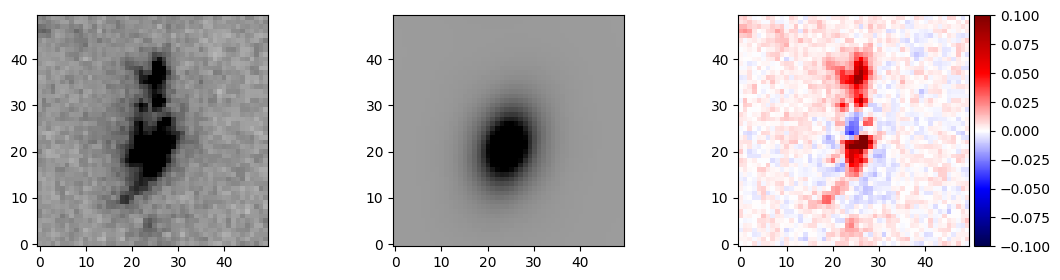

In [53]:
# Create dictionaries for IM data, each model, and residuals
filter_list = ["f090w", "f115w", "f150w", "f182m", "f200w", "f210m", "f277w", "f356w", "f410m", "f444w"]

input_dict = {}
single_models = {}
single_residuals = {}
new_dict = {}

# loading in posteriors for each filter from pysersic fits
for ii_f in filter_list:
    im, mask, sig, psf = load_data(filter=ii_f)
    input_dict[ii_f] = {'im': im, 'mask': mask, 'sig': sig, 'psf': psf}
    
    file_path = os.path.join(path_wdir, 'Output', f'fit_{ii_f}.asdf')

    af = asdf.open(file_path)

    # rms=af['input_data']['rms']
    # im=af['input_data']['image']

    posterior=af.tree['posterior']
    res = {}
    for a, b in zip(posterior.keys(), posterior.values()):
        res[a] = np.percentile(b, 50)
    new_dict[ii_f]= res	#new_dict =split_dict(res)
    #dict=af.tree

    for key, value in new_dict.items():
    #if key==0:
        single_models[key] = HybridRenderer(im.shape, jnp.array(af.tree['input_data']['psf'])).render_source(value, profile_type="sersic")
print("Sample Residual:")
ii_f = 'f115w'
plot_residual(input_dict[ii_f]['im'].astype(float), single_models[ii_f], vmin=-0.1, vmax=0.1)
plt.show()

data looks good!


C:\Users\kings\AppData\Local\Temp\ipykernel_20880\3855803909.py:63: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  bf_model0 = HybridRenderer(im.shape, jnp.array(psf.astype(np.float32))).render_source(dict_0, profile_type = 'sersic')
C:\Users\kings\AppData\Local\Temp\ipykernel_20880\3855803909.py:64: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  bf_model1 = HybridRenderer(im.shape, jnp.array(psf.astype(np.float32))).render_source(dict_1, profile_type = 'pointsource')
C:\Users\kings\AppData\Local\Temp\ipykernel_20880\3855803909.py:65: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  bf_model2 = HybridRenderer(im.shape, jnp.array(psf.astype(np.float32))).render_source(dict_2, profile_type = 'sersic')
C:\Users\kings\AppData\Local\Temp\ipykernel_20880\3855803909.py:66: 

data looks good!


C:\Users\kings\AppData\Local\Temp\ipykernel_20880\3855803909.py:63: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  bf_model0 = HybridRenderer(im.shape, jnp.array(psf.astype(np.float32))).render_source(dict_0, profile_type = 'sersic')
C:\Users\kings\AppData\Local\Temp\ipykernel_20880\3855803909.py:64: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  bf_model1 = HybridRenderer(im.shape, jnp.array(psf.astype(np.float32))).render_source(dict_1, profile_type = 'pointsource')
C:\Users\kings\AppData\Local\Temp\ipykernel_20880\3855803909.py:65: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  bf_model2 = HybridRenderer(im.shape, jnp.array(psf.astype(np.float32))).render_source(dict_2, profile_type = 'sersic')
C:\Users\kings\AppData\Local\Temp\ipykernel_20880\3855803909.py:66: 

data looks good!


C:\Users\kings\AppData\Local\Temp\ipykernel_20880\3855803909.py:64: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  bf_model1 = HybridRenderer(im.shape, jnp.array(psf.astype(np.float32))).render_source(dict_1, profile_type = 'pointsource')
C:\Users\kings\AppData\Local\Temp\ipykernel_20880\3855803909.py:65: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  bf_model2 = HybridRenderer(im.shape, jnp.array(psf.astype(np.float32))).render_source(dict_2, profile_type = 'sersic')
C:\Users\kings\AppData\Local\Temp\ipykernel_20880\3855803909.py:66: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  bf_model3 = HybridRenderer(im.shape, jnp.array(psf.astype(np.float32))).render_source(dict_3, profile_type = 'sersic')
C:\Users\kings\AppData\Local\Temp\ipykernel_20880\3855803909.py:63: 

data looks good!


C:\Users\kings\AppData\Local\Temp\ipykernel_20880\3855803909.py:65: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  bf_model2 = HybridRenderer(im.shape, jnp.array(psf.astype(np.float32))).render_source(dict_2, profile_type = 'sersic')
C:\Users\kings\AppData\Local\Temp\ipykernel_20880\3855803909.py:66: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  bf_model3 = HybridRenderer(im.shape, jnp.array(psf.astype(np.float32))).render_source(dict_3, profile_type = 'sersic')
C:\Users\kings\AppData\Local\Temp\ipykernel_20880\3855803909.py:63: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  bf_model0 = HybridRenderer(im.shape, jnp.array(psf.astype(np.float32))).render_source(dict_0, profile_type = 'sersic')
C:\Users\kings\AppData\Local\Temp\ipykernel_20880\3855803909.py:64: UserW

data looks good!


C:\Users\kings\AppData\Local\Temp\ipykernel_20880\3855803909.py:65: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  bf_model2 = HybridRenderer(im.shape, jnp.array(psf.astype(np.float32))).render_source(dict_2, profile_type = 'sersic')
C:\Users\kings\AppData\Local\Temp\ipykernel_20880\3855803909.py:66: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  bf_model3 = HybridRenderer(im.shape, jnp.array(psf.astype(np.float32))).render_source(dict_3, profile_type = 'sersic')


data looks good!


C:\Users\kings\AppData\Local\Temp\ipykernel_20880\3855803909.py:63: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  bf_model0 = HybridRenderer(im.shape, jnp.array(psf.astype(np.float32))).render_source(dict_0, profile_type = 'sersic')
C:\Users\kings\AppData\Local\Temp\ipykernel_20880\3855803909.py:64: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  bf_model1 = HybridRenderer(im.shape, jnp.array(psf.astype(np.float32))).render_source(dict_1, profile_type = 'pointsource')
C:\Users\kings\AppData\Local\Temp\ipykernel_20880\3855803909.py:65: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  bf_model2 = HybridRenderer(im.shape, jnp.array(psf.astype(np.float32))).render_source(dict_2, profile_type = 'sersic')
C:\Users\kings\AppData\Local\Temp\ipykernel_20880\3855803909.py:66: 

data looks good!


C:\Users\kings\AppData\Local\Temp\ipykernel_20880\3855803909.py:63: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  bf_model0 = HybridRenderer(im.shape, jnp.array(psf.astype(np.float32))).render_source(dict_0, profile_type = 'sersic')
C:\Users\kings\AppData\Local\Temp\ipykernel_20880\3855803909.py:64: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  bf_model1 = HybridRenderer(im.shape, jnp.array(psf.astype(np.float32))).render_source(dict_1, profile_type = 'pointsource')
C:\Users\kings\AppData\Local\Temp\ipykernel_20880\3855803909.py:65: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  bf_model2 = HybridRenderer(im.shape, jnp.array(psf.astype(np.float32))).render_source(dict_2, profile_type = 'sersic')
C:\Users\kings\AppData\Local\Temp\ipykernel_20880\3855803909.py:66: 

data looks good!


C:\Users\kings\AppData\Local\Temp\ipykernel_20880\3855803909.py:63: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  bf_model0 = HybridRenderer(im.shape, jnp.array(psf.astype(np.float32))).render_source(dict_0, profile_type = 'sersic')
C:\Users\kings\AppData\Local\Temp\ipykernel_20880\3855803909.py:64: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  bf_model1 = HybridRenderer(im.shape, jnp.array(psf.astype(np.float32))).render_source(dict_1, profile_type = 'pointsource')
C:\Users\kings\AppData\Local\Temp\ipykernel_20880\3855803909.py:65: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  bf_model2 = HybridRenderer(im.shape, jnp.array(psf.astype(np.float32))).render_source(dict_2, profile_type = 'sersic')
C:\Users\kings\AppData\Local\Temp\ipykernel_20880\3855803909.py:66: 

data looks good!


C:\Users\kings\AppData\Local\Temp\ipykernel_20880\3855803909.py:63: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  bf_model0 = HybridRenderer(im.shape, jnp.array(psf.astype(np.float32))).render_source(dict_0, profile_type = 'sersic')
C:\Users\kings\AppData\Local\Temp\ipykernel_20880\3855803909.py:64: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  bf_model1 = HybridRenderer(im.shape, jnp.array(psf.astype(np.float32))).render_source(dict_1, profile_type = 'pointsource')
C:\Users\kings\AppData\Local\Temp\ipykernel_20880\3855803909.py:65: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  bf_model2 = HybridRenderer(im.shape, jnp.array(psf.astype(np.float32))).render_source(dict_2, profile_type = 'sersic')
C:\Users\kings\AppData\Local\Temp\ipykernel_20880\3855803909.py:66: 

data looks good!


C:\Users\kings\AppData\Local\Temp\ipykernel_20880\3855803909.py:63: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  bf_model0 = HybridRenderer(im.shape, jnp.array(psf.astype(np.float32))).render_source(dict_0, profile_type = 'sersic')
C:\Users\kings\AppData\Local\Temp\ipykernel_20880\3855803909.py:64: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  bf_model1 = HybridRenderer(im.shape, jnp.array(psf.astype(np.float32))).render_source(dict_1, profile_type = 'pointsource')
C:\Users\kings\AppData\Local\Temp\ipykernel_20880\3855803909.py:65: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  bf_model2 = HybridRenderer(im.shape, jnp.array(psf.astype(np.float32))).render_source(dict_2, profile_type = 'sersic')
C:\Users\kings\AppData\Local\Temp\ipykernel_20880\3855803909.py:66: 

Sample Residual:


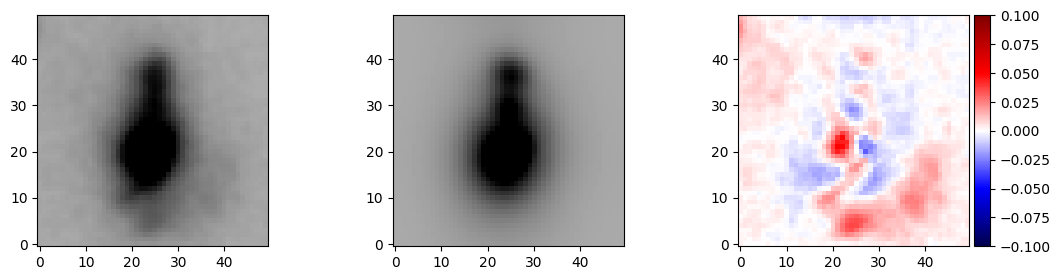

In [54]:

# loading in data for multicomponent fit and saving to dicts

mcomp_dict = {}
for ii_f in filter_list:
    im, mask, sig, psf = load_data(filter=ii_f)
    input_dict[ii_f] = {'im': im, 'mask': mask, 'sig': sig, 'psf': psf}
    
    file_path = os.path.join(path_wdir, 'Output', f'4compSVI_{ii_f}.asdf')

    af = asdf.open(file_path)

    # rms=af['input_data']['rms']
    # im=af['input_data']['image']

    posterior=af.tree['posterior']
    # res = af['best_model_params'] 
    dict = {}
    for a, b in zip(posterior.keys(), posterior.values()):
        # e.g. a = ellip_0, b = array?
        dict[a] = np.percentile(b, 50)
 
    # dict = {}
    # for a, b in zip(summary.index, summary["mean"]):
    #     dict[a] = b

    dict_0 = {'xc': dict['xc_0'], 
        'yc': dict['yc_0'], 
        'r_eff': dict['r_eff_0'], 
        'n': dict['n_0'], 
        'ellip': dict['ellip_0'], 
        'flux': dict['flux_0'], 
        'theta': dict['theta_0'],
        'f_1': 1}

    dict_1 = {'xc': dict['xc_1'], 
        'yc': dict['yc_1'], 
        # 'r_eff': dict['r_eff_1'], 
        # 'n': dict['n_1'], 
        # 'ellip': dict['ellip_1'], 
        'flux': dict['flux_1'], 
        # 'theta': dict['theta_1'],
        'f_1': 1}

    dict_2 = {'xc': dict['xc_2'], 
        'yc': dict['yc_2'], 
        'r_eff': dict['r_eff_2'], 
        'n': dict['n_2'], 
        'ellip': dict['ellip_2'], 
        'flux': dict['flux_2'], 
        'theta': dict['theta_2'],
        'f_1': 1}    


    dict_3 = {'xc': dict['xc_3'], 
        'yc': dict['yc_3'], 
        'r_eff': dict['r_eff_3'], 
        'n': dict['n_3'], 
        'ellip': dict['ellip_3'], 
        'flux': dict['flux_3'], 
        'theta': dict['theta_3'],
        'f_1': 1} 

    bf_model0 = HybridRenderer(im.shape, jnp.array(psf.astype(np.float32))).render_source(dict_0, profile_type = 'sersic')
    bf_model1 = HybridRenderer(im.shape, jnp.array(psf.astype(np.float32))).render_source(dict_1, profile_type = 'pointsource')
    bf_model2 = HybridRenderer(im.shape, jnp.array(psf.astype(np.float32))).render_source(dict_2, profile_type = 'sersic')
    bf_model3 = HybridRenderer(im.shape, jnp.array(psf.astype(np.float32))).render_source(dict_3, profile_type = 'sersic')

    bf_model = bf_model0 + bf_model1 + bf_model2 + bf_model3
    mcomp_dict[ii_f] = bf_model
print("Sample Residual:")
ii_f = 'f444w'
plot_residual(input_dict[ii_f]['im'].astype(float), mcomp_dict[ii_f], vmin=-0.1, vmax=0.1)
plt.show()

C:\Users\kings\AppData\Local\Temp\ipykernel_20880\2146296126.py:16: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  model = HybridRenderer(im.shape, jnp.array(psf.astype(np.float32))).render_source(bf_params, profile_type = 'sersic')


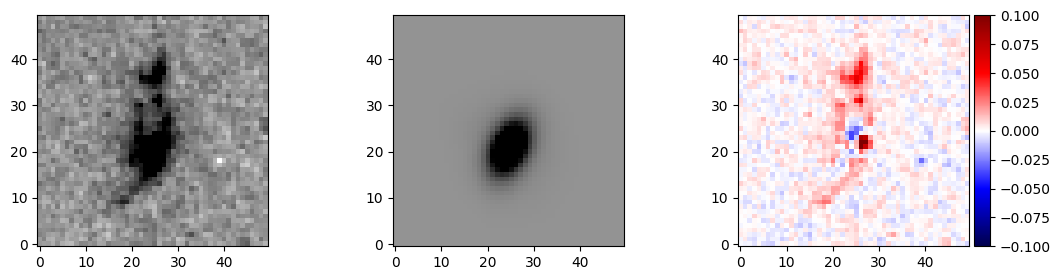

In [52]:
# testrun on single image

file_path = os.path.join(path_wdir, 'Output', f'fit_f090w.asdf')
af = asdf.open(file_path)

posterior=af.tree['posterior']
# res = af['best_model_params'] 
bf_params = {}
for a, b in zip(posterior.keys(), posterior.values()):
    # e.g. a = ellip_0, b = array?
    bf_params[a] = np.percentile(b, 50)
# bf_params = af['best_model_params']
im = af['input_data']['image']
psf = af['input_data']['psf']
bf_params
model = HybridRenderer(im.shape, jnp.array(psf.astype(np.float32))).render_source(bf_params, profile_type = 'sersic')
plot_residual(im.astype(float), model, vmin=-0.1, vmax=0.1)
plt.show()

In [55]:
single_residuals = {}
multi_residuals = {}
for ii_f in filter_list:
    singleres = input_dict[ii_f]['im'] - np.array(single_models[ii_f])
    single_residuals[ii_f] = singleres
    multires = input_dict[ii_f]['im'] -np.array(mcomp_dict[ii_f])
    multi_residuals[ii_f] = multires
    

In [46]:
# Single residuals dict is models
ii_f = 'f444w'
chi1 = single_residuals[ii_f] / input_dict[ii_f]['sig']
chi1_squared = np.sum(chi1**2)
print(chi1_squared)

chi2 = multi_residuals[ii_f] / input_dict[ii_f]['sig']
chi2_squared = np.sum(chi2**2)
print(chi2_squared)


927.5105
562.19324


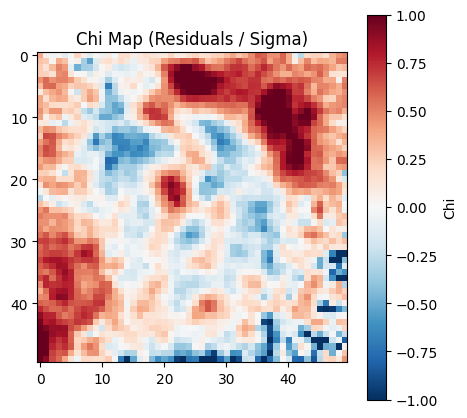

In [56]:
# visualizing chi map for single vs multicomponent fit

plt.figure(figsize=(5, 5))
plt.imshow(chi2, cmap='RdBu_r', vmin=-1, vmax=1)  # Clip extreme values for better contrast
plt.colorbar(label="Chi")
plt.title("Chi Map (Residuals / Sigma)")
plt.show()

Plotting the single comp model:

<>:62: SyntaxWarning: invalid escape sequence '\c'
<>:62: SyntaxWarning: invalid escape sequence '\c'
C:\Users\kings\AppData\Local\Temp\ipykernel_20880\571599583.py:62: SyntaxWarning: invalid escape sequence '\c'
  fig.suptitle(f'Single-Component Model; $\chi^2$ = {chi1_squared.astype(int)}', fontsize=20, y=1.02)


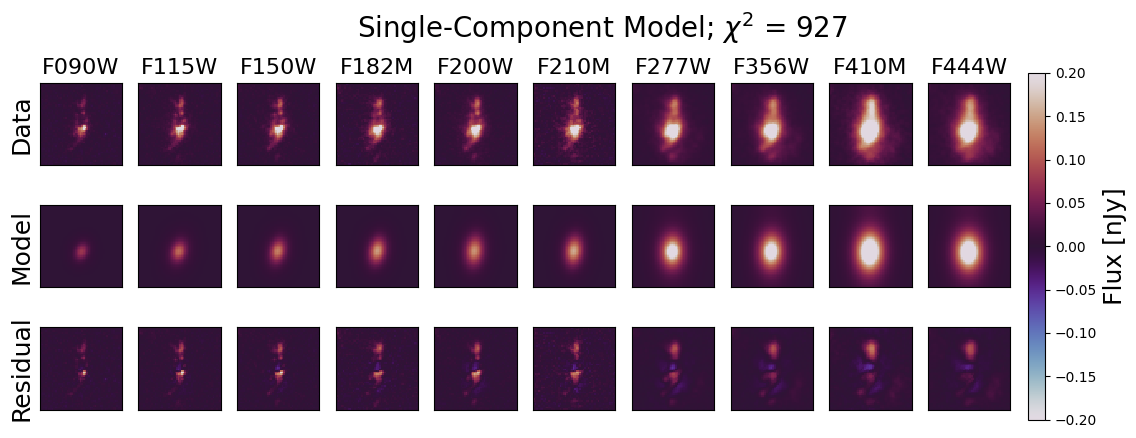

In [49]:
from astropy.visualization import ImageNormalize, LogStretch, simple_norm

filt_list = ["F090W", "F115W", "F150W", "F182M", "F200W", "F210M", "F277W", "F356W", "F410M", "F444W"]

fig, ax=plt.subplots(nrows=3, ncols=len(filt_list), figsize=(15, 4.5))

for i, ii_f in enumerate(filter_list):
   
    # Open data from each FITs file for each
    ims=input_dict[ii_f]['im']            #fits.open(image_list[0])[1].data
    array_res=single_residuals[ii_f]          #fits.open(res_list[0])[1].data
    array_model=single_models[ii_f]          #fits.open(mod_list[0])[1].data
    std_resid = np.std(input_dict[ii_f]['im'])

    # # Chi Values:
    # chi = single_residuals[ii_f] / input_dict[ii_f]['sig']
    # chi_squared = np.sum(chi**2)
    # print(chi_squared)

    # chi = multi_residuals[ii_f] / input_dict[ii_f]['sig']
    # chi_squared = np.sum(chi**2)
    # print(chi_squared)

    norm = ImageNormalize(vmin=-.2, vmax=.2)
    vmin, vmax= 0.001, 0.35 # std_resid * -scale, std_resid * scale

    vmin_res, vmax_res=-.3,.3
    cm='RdGy'
    cm2='twilight'

    # if i<=2:
    pl1 = ax[0,i].imshow(ims, origin='lower', norm=norm, cmap=cm2, interpolation = 'nearest')
    ax[0,i].set_title(f'{filt_list[i]}', fontsize=16)
    ax[1,i].imshow(array_model, origin='lower', norm=norm, cmap=cm2, interpolation = 'nearest')
    pl_res=ax[2,i].imshow(array_res, origin='lower', norm=norm, cmap=cm2, interpolation = 'nearest')


    if i==len(filt_list)-1:
        
        cbar=fig.colorbar(pl_res, ax=ax[:,:],pad=0.015, label='Flux [MJy]')
        cbar.set_label(r'Flux [nJy]', fontsize=18)
        cbar.ax.tick_params(labelsize=10)

    if filt_list[i]=='F090W': 
        ax[0,i].set_ylabel('Data', fontsize=18)
        ax[1,i].set_ylabel('Model', fontsize=18)
        ax[2,i].set_ylabel('Residual', fontsize=18)

for i in range(len(ax[0,:])):
    
    ax[0,i].get_xaxis().set_visible(False)
    ax[0,i].set_yticks([])

    ax[1,i].get_xaxis().set_visible(False)
    ax[1,i].set_yticks([])
    #ax[1,i].get_yaxis().set_visible(False)

    ax[2,i].get_xaxis().set_visible(False)
    ax[2,i].set_yticks([])
    #ax[2,i].get_yaxis().set_visible(False)

fig.suptitle(f'Single-Component Model; $\chi^2$ = {chi1_squared.astype(int)}', fontsize=20, y=1.02)
    # plt.show()
# fig.savefig(f'singlemodelcomparison.pdf', dpi=300, bbox_inches='tight')
plt.show()

Plotting the 4-comp model:

<>:66: SyntaxWarning: invalid escape sequence '\c'
<>:66: SyntaxWarning: invalid escape sequence '\c'
C:\Users\kings\AppData\Local\Temp\ipykernel_20880\131506866.py:66: SyntaxWarning: invalid escape sequence '\c'
  fig.suptitle(f'Multi-Component Model; $\chi^2$ = {chi2_squared.astype(int)}', fontsize=20, y=1.02)


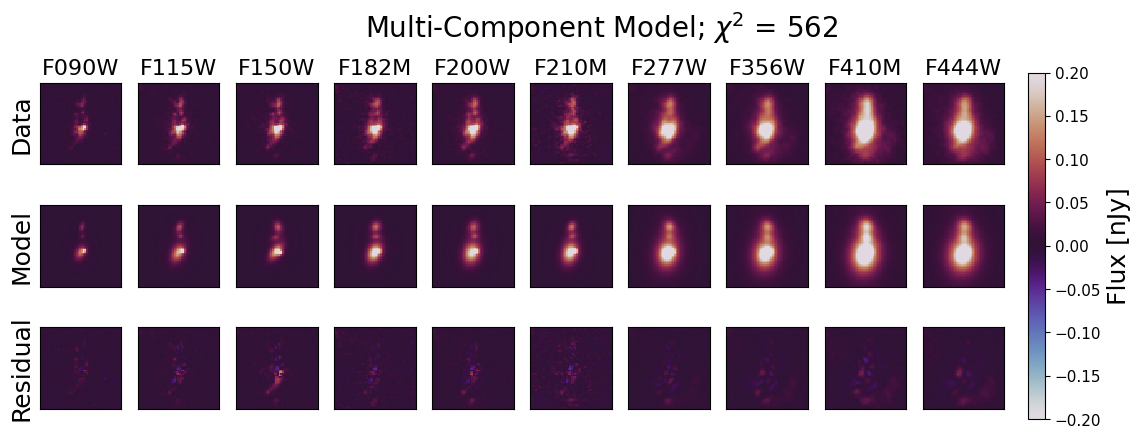

In [ ]:
from astropy.visualization import ImageNormalize, LogStretch, simple_norm

filt_list = ["F090W", "F115W", "F150W", "F182M", "F200W", "F210M", "F277W", "F356W", "F410M", "F444W"]

fig, ax=plt.subplots(nrows=3, ncols=len(filt_list), figsize=(15, 4.5))

for i, ii_f in enumerate(filter_list):
    # Open data from each FITs file for each
    ims=input_dict[ii_f]['im']            #fits.open(image_list[0])[1].data
    array_res=multi_residuals[ii_f]          #fits.open(res_list[0])[1].data
    array_model=mcomp_dict[ii_f]          #fits.open(mod_list[0])[1].data
    std_resid = np.std(input_dict[ii_f]['im'])

    # # Chi Values:
    # chi = single_residuals[ii_f] / input_dict[ii_f]['sig']
    # chi_squared = np.sum(chi**2)
    # print(chi_squared)

    # chi = multi_residuals[ii_f] / input_dict[ii_f]['sig']
    # chi_squared = np.sum(chi**2)
    # print(chi_squared)

    norm = ImageNormalize(vmin=-.2, vmax=.2)
    vmin, vmax= 0.001, 0.35 # std_resid * -scale, std_resid * scale

    vmin_res, vmax_res=-.3,.3

    # cm='plasma'
    cm='RdGy'
    cm2='twilight'

    # if i<=2:
    pl1 = ax[0,i].imshow(ims, origin='lower', norm=norm, cmap=cm2, interpolation = 'nearest')
    ax[0,i].set_title(f'{filt_list[i]}', fontsize=16)
    ax[1,i].imshow(array_model, origin='lower', norm=norm, cmap=cm2, interpolation = 'nearest')
    pl_res=ax[2,i].imshow(array_res, origin='lower', norm=norm, cmap=cm2, interpolation = 'nearest')

    if i==len(filt_list)-1:
        
        cbar=fig.colorbar(pl_res, ax=ax[:,:],pad=0.02, label='Flux [MJy]')
        cbar.set_label(r'Flux [nJy]', fontsize=18)
        cbar.ax.tick_params(labelsize=11)


    if filt_list[i]=='F090W': 
        ax[0,i].set_ylabel('Data', fontsize=18)
        ax[1,i].set_ylabel('Model', fontsize=18)
        ax[2,i].set_ylabel('Residual', fontsize=18)

for i in range(len(ax[0,:])):
    
    ax[0,i].get_xaxis().set_visible(False)
    ax[0,i].set_yticks([])

    ax[1,i].get_xaxis().set_visible(False)
    ax[1,i].set_yticks([])
    #ax[1,i].get_yaxis().set_visible(False)

    ax[2,i].get_xaxis().set_visible(False)
    ax[2,i].set_yticks([])
    #ax[2,i].get_yaxis().set_visible(False)
    
    # from chi_check import chi_run
    # chi=chi_run(args.name, args.ids)

fig.suptitle(f'Multi-Component Model; $\chi^2$ = {chi2_squared.astype(int)}', fontsize=20, y=1.02)
# fig.savefig(f'multimodelcomparison.pdf', dpi=300, bbox_inches='tight')
plt.show()

### Latex table-making code (for the thesis)

In [58]:

input_dict = {}
single_bf = {}
multi_bf = {}
single_residuals = {}
new_dict = {}
for ii_f in filter_list:
    file_path = os.path.join(path_wdir, 'Output', f'fit_{ii_f}.asdf')

    af = asdf.open(file_path)

    posterior=af.tree['posterior']
    res = {}
    for a, b in zip(posterior.keys(), posterior.values()):
        res[a] = np.percentile(b, 50) # res is a dict of params and their values 1:1
    res.pop('sys_rms')
    # want dict of filters with param dicts
    single_bf[ii_f.upper()] = res

    file_path2 = os.path.join(path_wdir, 'Output', f'4compSVI_{ii_f}.asdf')
    
    af = asdf.open(file_path2)

    posterior=af.tree['posterior']
    res = {}
    for a, b in zip(posterior.keys(), posterior.values()):
        res[a] = np.percentile(b, 50) # res is a dict of params and their values 1:1
    # res.pop('sys_rms')
    # want dict of filters with param dicts
    multi_bf[ii_f.upper()] = res


In [ ]:
import pandas as pd

# Load the CSV file
df = pd.read_csv(r'D:\Programming\Cambridge\4compSVI_fluxes_nJy.csv')

# Assuming your CSV columns are named like:
# 'filter', 'flux_0s', 'flux_0s_delta_lower', 'flux_0s_delta_upper', ...

# Prepare for LaTeX table rows
rows = []

# Add the header row
header = "Filter & 0 Flux & 1 Flux & 2 Flux & 3 Flux \\\\ \\hline"
rows.append(header)

# Loop through each filter and its corresponding flux and errors
for _, row in df.iterrows():
    row_data = [row['filter']]  # Filter name (assuming a column named 'filter')
    
    # Loop through fluxes and error columns (assuming they follow this pattern)
    for i in range(4):  # Assuming 4 flux components: 0, 1, 2, 3
        flux_col = f'flux_{i}s'
        lower_col = f'flux_{i}s_delta_lower'
        upper_col = f'flux_{i}s_delta_upper'

        val = row[flux_col]
        lo = row[lower_col]
        hi = row[upper_col]
        
        # Calculate asymmetric errors
        plus = hi - val
        minus = val - lo
        entry = f"${val:.2f}^{{+{plus:.2f}}}_{{-{minus:.2f}}}$"
        
        row_data.append(entry)
    
    # Add this row to the LaTeX table rows list
    rows.append(" & ".join(row_data) + " \\\\")
# Combine everything into a full LaTeX table
latex_table = "\\begin{tabular}{lcccc}\n" + "\n".join(rows) + "\n\\end{tabular}"

# Print or save the table
print(latex_table)

\begin{tabular}{lcccc}
Filter & 0 Flux & 1 Flux & 2 Flux & 3 Flux \\ \hline
F090W & $114.53^{+-107.49}_{-107.28}$ & $24.99^{+-20.60}_{-20.30}$ & $10.16^{+-7.29}_{-7.29}$ & $27.31^{+-24.21}_{-24.17}$ \\
F115W & $247.26^{+-236.25}_{-235.92}$ & $32.61^{+-27.68}_{-27.36}$ & $18.49^{+-13.85}_{-13.64}$ & $64.78^{+-59.03}_{-58.96}$ \\
F150W & $207.32^{+-198.69}_{-198.43}$ & $41.73^{+-36.76}_{-36.82}$ & $34.52^{+-28.68}_{-28.50}$ & $75.98^{+-69.83}_{-69.80}$ \\
F182M & $355.22^{+-341.39}_{-340.97}$ & $21.77^{+-16.29}_{-16.02}$ & $28.03^{+-22.19}_{-22.33}$ & $93.88^{+-87.10}_{-87.17}$ \\
F200W & $435.86^{+-421.40}_{-420.97}$ & $34.88^{+-29.02}_{-28.66}$ & $23.11^{+-17.30}_{-17.16}$ & $100.10^{+-93.01}_{-93.14}$ \\
F210M & $453.18^{+-438.15}_{-437.70}$ & $35.80^{+-29.80}_{-29.58}$ & $28.35^{+-21.84}_{-21.68}$ & $77.66^{+-71.60}_{-71.48}$ \\
F277W & $1006.72^{+-978.42}_{-977.57}$ & $57.89^{+-46.11}_{-45.95}$ & $48.57^{+-35.96}_{-35.96}$ & $157.89^{+-138.58}_{-138.25}$ \\
F356W & $1169.33^{+-1141.

In [ ]:

flux_data = [
    (flux_0s, flux_0s_errors_lower, flux_0s_errors_upper),
    (flux_1s, flux_1s_errors_lower, flux_1s_errors_upper),
    (flux_2s, flux_2s_errors_lower, flux_2s_errors_upper),
    (flux_3s, flux_3s_errors_lower, flux_3s_errors_upper)
]

# Create LaTeX table rows
rows = []
for i, filt in enumerate(filter_list):
    row = [filt]
    for flux, err_lo, err_hi in flux_data:
        val = flux[i]
        minus = err_lo[i]
        plus = err_hi[i]
        entry = f"${val:.2f}^{{+{plus:.2f}}}_{{-{minus:.2f}}}$"
        row.append(entry)
    rows.append(" & ".join(row) + " \\\\")
print(row[1])
# Output LaTeX table
header = "Filter & 0 Flux & 1 Flux & 2 Flux & 3 Flux \\\\ \\hline"
latex_table = "\\begin{tabular}{lcccc}\n" + header + "\n" + "\n".join(rows) + "\n\\end{tabular}"

# Save or print
print(latex_table)


$68514459156480.00^{+1214325456896.00}_{-1250818392064.00}$
\begin{tabular}{lcccc}
Filter & 0 Flux & 1 Flux & 2 Flux & 3 Flux \\ \hline
f090w & $4865209663488.00^{+298935451648.00}_{-307916210176.00}$ & $1061588631552.00^{+186709098496.00}_{-199306412032.00}$ & $431712239616.00^{+122114899968.00}_{-122087161856.00}$ & $1160078032896.00^{+131794018304.00}_{-133406253056.00}$ \\
f115w & $10473774776320.00^{+466385862656.00}_{-480397590528.00}$ & $1381498093568.00^{+209013932032.00}_{-222657691648.00}$ & $783236726784.00^{+196399333376.00}_{-205524385792.00}$ & $2743968202752.00^{+243653771264.00}_{-246500360192.00}$ \\
f150w & $8810590633984.00^{+366733393920.00}_{-377751896064.00}$ & $1773276364800.00^{+211183910912.00}_{-208414736384.00}$ & $1467122188288.00^{+248351719424.00}_{-255858524160.00}$ & $3228786753536.00^{+261196169216.00}_{-262316785664.00}$ \\
f182m & $15112914075648.00^{+588508299264.00}_{-606187618304.00}$ & $925998514176.00^{+232877260800.00}_{-244318978048.00}$ & $119

In [ ]:
# import pandas as pd
# pd.options.display.float_format = "{:,.2f}".format
# # Convert Lists to DataFrame
# # Use pandas to convert the lists into a DataFrame
# # Create a dictionary with the lists
# data = {
#     'single_bf': single_bf.values()
# }

# # Convert the dictionary to a DataFrame
# df = pd.DataFrame(single_bf.values(), index=filter_list)
# df.index = df.index.str.upper()
# df.to_csv('singlecompparams.csv', index=True)

# Compiling Prospector + pysersic data
Preliminary code to load in the required data for final plotting of the mass distribution;
i.e., the results of the PySersic and Prospector fits.

In [62]:
import asdf
import os

from astropy.cosmology import Planck18 as cosmo 

# Define the path to the directory containing the ASDF files
# filter_name = "f090w"
path_wdir = f'D:\\Programming\\Cambridge\\Enso Data'
filter_list = ["F090W", "F115W", "F150W", "F182M", "F200W", "F210M", "F277W", "F356W", "F410M", "F444W"]

for filter_name in filter_list:
    file_path = os.path.join(path_wdir, 'Output', f'4compSVI_{filter_name}.asdf')
    with asdf.open(file_path) as af:
        flux_0 = af['posterior']['flux_0'].mean()
        
        params_single = list(af['posterior'].keys())

params_single[3]

'flux_0'

In [63]:
# converting flux units:
# Flux is Energy / area
# Raw unit is MJy/sr / pixel,
# current output is "for x source, total flux is (y) MJy/sr /pixel"
# Pixel area in sr (sr / px) = PIXAR_SR
# so want flux * pixar_sr
pixar_vals = []
for i, f in enumerate(filter_list):
        # load image data
        fname = (file_core + f + '.fits')
        with fits.open(fname) as hdul:
            header = hdul[0].header
            pixar_vals.append(header['PIXAR_SR'])

print(pixar_vals)

[2.11791053341201e-14, 2.12390131173457e-14, 2.11701369095792e-14, 2.11465740855696e-14, 2.12239146123051e-14, 2.11465740855697e-14, 2.11465740855697e-14, 2.11465740855697e-14, 2.11465740855697e-14, 2.11465740855697e-14]


In [64]:
import asdf
import copy
asdf_dict = {}
cnames = ['Core', 'Point Source', 'Minor Clump', 'Major Clump']
with asdf.open(r'D:\Programming\Cambridge\Enso Data\sfh_data.asdf') as af:
    asdf_dict = copy.deepcopy(af.tree)

sfh_dict = {}
for i in cnames:
    sfh_dict[i] = asdf_dict[i]
sfh_dict['Core'].keys()

C:\Users\kings\AppData\Roaming\Python\Python312\site-packages\asdf\_asdf.py:388: AsdfPackageVersionWarning: File 'file:///D:/Programming/Cambridge/Enso%20Data/sfh_data.asdf' was created with extension URI 'asdf://asdf-format.org/core/extensions/core-1.6.0' (from package asdf==4.1.0), but older package (asdf==3.5.0) is installed.
  warnings.warn(msg, AsdfPackageVersionWarning)


dict_keys(['cmap', 'cmap2', 'log_mass_formed', 'log_msun', 'sfh_params', 'sfh_q16', 'sfh_q50', 'sfh_q84', 'sfh_t', 'sfr_100_Myr', 'sfr_data'])

In [65]:
sfh_dict['Core']['sfr_data'].keys()

dict_keys(['sfr_100_Myr', 'sfr_10_Myr', 'sfr_2000_Myr', 'sfr_50_Myr', 'sfr_5_Myr'])

In [ ]:
# sersic_params = {}

# for filter_name in filter_list:
#     sersic_params[filter_name] = {}
#     file_path = os.path.join(path_wdir, 'Output', f'4compSVI_{filter_name}.asdf')

#     with asdf.open(file_path) as af:
#         for i, cname in enumerate(cnames):
#             sersic_params[filter_name][cname] = {}  # <- create per-component dict
#             fdict = sersic_params[filter_name][cname]
#             for param in params:
#                 if i == 1 and param == 'n':
#                     fdict[param] = {'med': 1}
#                 elif i == 1 and param == 'r_eff':
#                     fdict[param] = {'med': 0.5}
#                 elif i == 1 and param in ('ellip', 'theta'):
#                     fdict[param] = {'med': 0.0}
#                 else:
#                     key = f'{param}_{i}'
#                     if key in af['posterior']:
#                         fdict[param] = {
#                             'med': np.median(af['posterior'][key]),
#                             'low': np.percentile(af['posterior'][key], 16),
#                             'up':  np.percentile(af['posterior'][key], 84),
#                         }
#                         fdict[param]['sigma'] = (fdict[param]['up'] - fdict[param]['low']) / 2
#                     else:
#                         fdict[param] = {'med': None}  # or skip/raise if key missing

# # Then attach to sfh_dict
# for cname in cnames:
#     sfh_dict[cname]['sersic_params'] = {f: sersic_params[f][cname] for f in filter_list}

# sfh_dict[cname]['sersic_params'][filter_name]['n']


In [ ]:
# with asdf.AsdfFile(sfh_dict) as af:
#     af.write_to("all_params.asdf")

## Mass Mapping
Constructing stellar and gas mass maps using the input data, alongside the results of the dynamical modeling.

Load posteriors into a single dict:

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.modeling.functional_models import Sersic2D
import asdf
import copy


asdf_dict = {}
cnames = ['Core', 'Point Source', 'Minor Clump', 'Major Clump']
with asdf.open(r'D:\Programming\Cambridge\Enso Data\sfh_data.asdf') as af:
    asdf_dict = copy.deepcopy(af.tree)

sfh_dict = {}
for cname in cnames:
    sfh_dict[cname] = asdf_dict[cname]
    # p = params_dict[cname]['sersic_params']['F356W']
    print("Component:", cname)
    print("Prospector logmass:", (sfh_dict[cname]['log_msun']))
    # print("Pysersic r_eff:", p['r_eff']['med'])
    print("######################")

with asdf.open(r'D:\Programming\Cambridge\all_params.asdf') as af:
    asdf_dict = copy.deepcopy(af.tree)
params_dict = {}
for cname in cnames:
    # load in pysersic params
    params_dict[cname] = asdf_dict[cname]
    # add sfh/mass dict to full params dict cname:cname
    params_dict[cname]['prospector'] = sfh_dict[cname]

Component: Core
Prospector logmass: 10.42817955376279
######################
Component: Point Source
Prospector logmass: 9.101400592668913
######################
Component: Minor Clump
Prospector logmass: 9.18365072668105
######################
Component: Major Clump
Prospector logmass: 9.15650674115597
######################


In [67]:
params_dict['Core']['prospector']['sfr_data']

{'sfr_100_Myr': 25.30111757662334,
 'sfr_10_Myr': 27.155582370037816,
 'sfr_2000_Myr': 19.117249544375273,
 'sfr_50_Myr': 23.404641708250157,
 'sfr_5_Myr': 29.552287044752717}

## 1 Filter sample

Create a single filter, single component sample of
- 2D sersic profile, plotted using pysersic posteriors
- multiplied by prospector's mass for that component
- giving: 2D distribution of estimated stellar mass


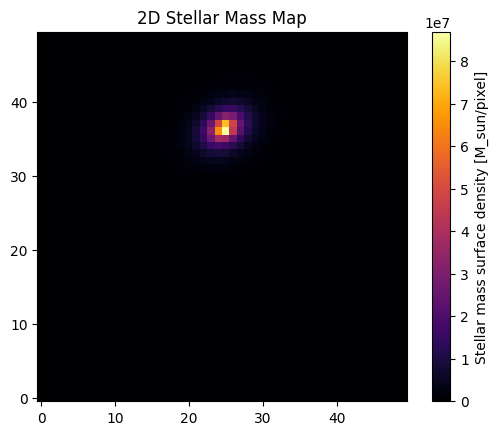

In [68]:

# 1. Define 2D grid
ysize, xsize = 50, 50
y, x = np.mgrid[0:ysize, 0:xsize]

# 2. Define component parameters

cname = 'Major Clump'
filter_name = 'F356W'
p = params_dict[cname]['sersic_params'][filter_name]
# convert mass
mass = 10 ** params_dict[cname]['prospector']['log_msun']

# Initialize final mass map
mass_map = np.zeros((50, 50))

# Create Sersic2D model
model = Sersic2D(
    amplitude=1,  # will scale after
    r_eff=p['r_eff']['med'],
    n=p['n']['med'],
    x_0=p['xc']['med'],
    y_0=p['yc']['med'],
    ellip=p['ellip']['med'],
    theta=p['theta']['med']
)

# Normalised profile
profile = model(x, y)
profile /= np.sum(profile)  # Normalize the profile

# Scale to stellar mass
mass_map += profile * mass 

# Plot
plt.imshow(mass_map, origin='lower', cmap='inferno')
plt.colorbar(label='Stellar mass surface density [M_sun/pixel]')
plt.title('2D Stellar Mass Map')
plt.show()

Repeat for each component to combine

In [69]:
from astropy.modeling.functional_models import Sersic2D

ny, nx = 50, 50

# setup grid
y, x = np.mgrid[0:ny, 0:nx]

mass_map = np.zeros((ny, nx))
# mass = 10 ** params_dict[cname]['prospector']['log_msun']

filter_name = 'F356W'

# Combine all components into a sersic model
for cname in cnames:
    p = params_dict[cname]['sersic_params'][filter_name]
    sersic = Sersic2D(amplitude=1,
                    r_eff=p['r_eff']['med'],
                    n=p['n']['med'],
                    # y, x, and theta flipped to realign
                    y_0=p['xc']['med'],
                    x_0=p['yc']['med'],
                    ellip=p['ellip']['med'],
                    theta=-p['theta']['med'])
    mass = 10 ** params_dict[cname]['prospector']['log_msun']
    print("Component:", cname)
    print("Prospector logmass:", params_dict[cname]['prospector']['log_msun'])
    print("Pysersic flux:", p['flux']['med'])
    print("######################")
    profile = sersic(x, y)
    profile /= profile.sum()  # normalize

    # Combine into mass map; transpose to realign
    mass_map += np.transpose((profile * mass))


Component: Core
Prospector logmass: 10.42817955376279
Pysersic flux: 55.26780700683594
######################
Component: Point Source
Prospector logmass: 9.101400592668913
Pysersic flux: 3.2273659706115723
######################
Component: Minor Clump
Prospector logmass: 9.18365072668105
Pysersic flux: 3.5014071464538574
######################
Component: Major Clump
Prospector logmass: 9.15650674115597
Pysersic flux: 7.810908317565918
######################


### Conversions; kpc & surface density

In [70]:
# Calculate the effective radius in kpc
redshift = 5.3281
pixel_scale =  0.029994742800210222  # sq root of fits; arcsec/pixel
kpc_per_arcsec = cosmo.kpc_proper_per_arcmin(redshift).value/60
kpc_per_pixel = pixel_scale * kpc_per_arcsec # arcsec/pixel * kpc/arcsec
pixel_area_kpc2 = (pixel_scale * kpc_per_arcsec) ** 2
surf_density_mass = mass_map / pixel_area_kpc2

x_kpc = np.arange(nx) * pixel_scale * kpc_per_arcsec
y_kpc = np.arange(ny) * pixel_scale * kpc_per_arcsec


In [71]:
9.51 * kpc_per_pixel

np.float64(1.7736015690256497)

Plot!

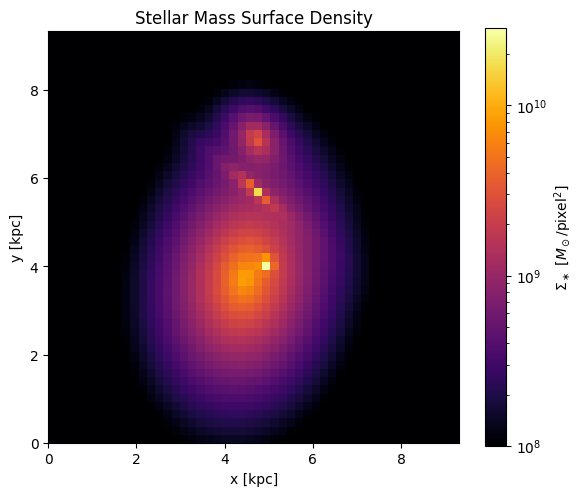

In [72]:
extent = [0, nx * kpc_per_pixel, 0, ny * kpc_per_pixel]  # extent in kpc

plt.figure(figsize=(6, 5))
plt.imshow(surf_density_mass, origin='lower', cmap='inferno', extent=extent, norm='log', vmin=1e8)  # or norm=LogNorm() if needed
plt.colorbar(label=r'$\Sigma_\ast$ [$M_\odot$/pixel$^2$]')
plt.title('Stellar Mass Surface Density')
plt.xlabel('x [kpc]')
plt.ylabel('y [kpc]')
plt.tight_layout()
plt.show()

Creating ellipses to sum mass over

In [74]:
# Surface brightness to flux converter
def Ie_to_flux(Ie,n,r_e,ellip):
    # calculate surface brightness at Re [in arcsec] from total flux [arbitrary flux units]
    bn = bn_approx(n)
    G2n = gamma(2*n)
    q = 1 - ellip
    total_flux = Ie* (r_e**2 * q * 2*jnp.pi * n * jnp.exp(bn) * bn**(-2*n) * G2n )
    return total_flux

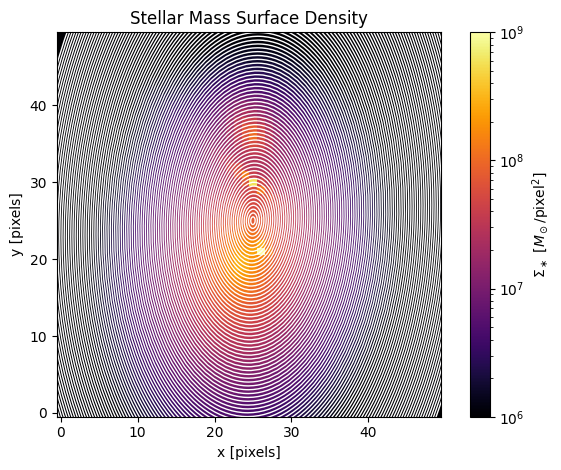

Total enclosed Mass: 3.10e+10
Total Mass Map: 3.10e+10


In [75]:
import numpy as np
from photutils.aperture import EllipticalAperture, aperture_photometry

# Inputs
positions = (25, 25)          # centre of the apertures
ellip = 0.43 #0.43          # ellipticity = (1 - b/a); 
r_eff = 100 # 9.51            # effective radius in pixels
a = r_eff               # semi-major axis
b_a = 1 - ellip  # semi-minor axis b = (ellip + 1) * a
theta = 1.53                # theta in radians


# Semi-major axis lengths (in pixels)
a_vals = np.linspace(0.5, 50, 100)

# Output array
masses = []
apertures = []

plt.imshow(mass_map, origin='lower', cmap='inferno', norm='log', vmin=1e6, vmax=1e9)  # or norm=LogNorm() if needed
plt.colorbar(label=r'$\Sigma_\ast$ [$M_\odot$/pixel$^2$]')
plt.title('Stellar Mass Surface Density')
plt.xlabel('x [pixels]')
plt.ylabel('y [pixels]')
plt.tight_layout()
# Loop over apertures
for a in a_vals:
    aperture = EllipticalAperture(positions, a, a * b_a, theta)
    apertures.append(aperture)  
    phot_table = aperture_photometry(mass_map, aperture)
    masses.append(phot_table['aperture_sum'][0])

for aperture in apertures:
    aperture.plot(color='white', lw=1)

plt.show()
print(f"Total enclosed Mass: {np.max(masses):.2e}")
print(f"Total Mass Map: {np.sum(mass_map):.2e}")

### Plotting Dynamical Mass as a fn. of radius

<>:5: SyntaxWarning: invalid escape sequence '\P'
<>:5: SyntaxWarning: invalid escape sequence '\P'
C:\Users\kings\AppData\Local\Temp\ipykernel_20880\1985307571.py:5: SyntaxWarning: invalid escape sequence '\P'
  data = np.loadtxt('D:\Programming\Cambridge\Enso Data\dynamicalmass.txt', comments='#')


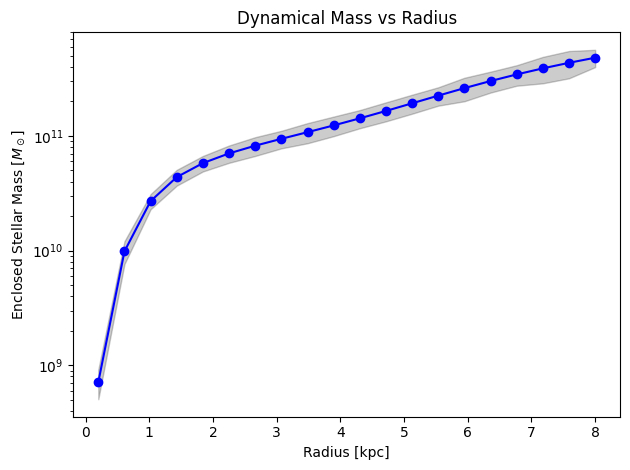

In [76]:
import numpy as np
import matplotlib.pyplot as plt

# Load the data, skipping the comment line
data = np.loadtxt('D:\Programming\Cambridge\Enso Data\dynamicalmass.txt', comments='#')

dyn_radius_kpc = data[:, 0]
dyn_mass_msun = data[:, 1]
dyn_mass_unc = data[:, 2]  

# Plot
plt.plot(dyn_radius_kpc, dyn_mass_msun, marker='o', linestyle='-', color='blue', label='Dynamical Mass')
plt.fill_between(dyn_radius_kpc,
                 dyn_mass_msun - dyn_mass_unc,
                 dyn_mass_msun + dyn_mass_unc,
                 color='black', alpha=0.2)
plt.xlabel(r'Radius [kpc]')
plt.ylabel(r'Enclosed Stellar Mass [$M_\odot$]')
plt.yscale('log')
plt.title('Dynamical Mass vs Radius')
# plt.grid(True)
plt.tight_layout()
plt.show()

In [77]:
a_vals_kpc = a_vals * kpc_per_pixel

<>:8: SyntaxWarning: invalid escape sequence '\o'
<>:8: SyntaxWarning: invalid escape sequence '\o'
C:\Users\kings\AppData\Local\Temp\ipykernel_20880\1550866666.py:8: SyntaxWarning: invalid escape sequence '\o'
  plt.ylabel('Total mass enclosed (M$_\odot$)')


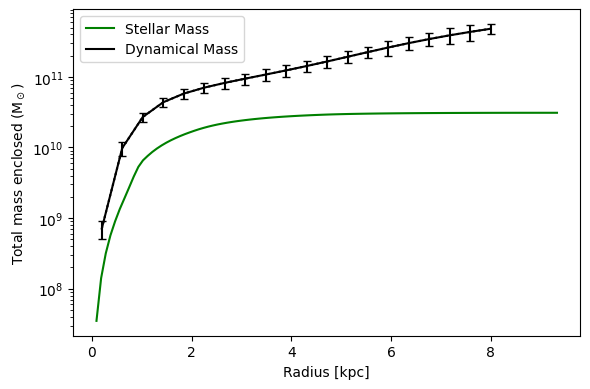

In [78]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(a_vals_kpc, masses, color='green')
plt.plot(dyn_radius_kpc, dyn_mass_msun, color='black')
plt.errorbar(dyn_radius_kpc, dyn_mass_msun, yerr=dyn_mass_unc, fmt=':', color='black', capsize=3)
plt.xlabel(r'Radius [kpc]')
plt.ylabel('Total mass enclosed (M$_\odot$)')
plt.yscale('log')
plt.legend(['Stellar Mass', 'Dynamical Mass'])
# plt.grid(True)
plt.tight_layout()
plt.show()


#### Comparing Aperture Mass to Prospector Mass

In [79]:
cmasses = []
for cname in cnames:
    mass = 10 ** params_dict[cname]['prospector']['log_msun']
    print(f'Prospector Mass for {cname}: {mass:.2e} M☉')
    cmasses.append(mass)
prosp_mass = np.sum(cmasses)
mass_within_ellipse = phot_table['aperture_sum'][0]  # in solar masses
print(f"Total Prospector Mass: {prosp_mass:.2e} M☉")
print(f"Total Aperture Mass: {mass_within_ellipse:.2e} M☉")
print(f"Total Dynamical Mass: {np.max(dyn_mass_msun[-1]):.2e} M☉")

Prospector Mass for Core: 2.68e+10 M☉
Prospector Mass for Point Source: 1.26e+09 M☉
Prospector Mass for Minor Clump: 1.53e+09 M☉
Prospector Mass for Major Clump: 1.43e+09 M☉
Total Prospector Mass: 3.10e+10 M☉
Total Aperture Mass: 3.10e+10 M☉
Total Dynamical Mass: 4.81e+11 M☉


In [80]:
10 ** 10.62 / 1e10

4.168693834703347

### Evaluating Gas Mass via SFR & Tacconi Relation

In [81]:
from astropy.modeling.functional_models import Sersic2D

ny, nx = 50, 50

# setup grid
y, x = np.mgrid[0:ny, 0:nx]

sfr_map = np.zeros((ny, nx))

filter_name = 'F356W'

# Combine all components into a sersic model
for cname in cnames:
    p = params_dict[cname]['sersic_params'][filter_name]
    sersic = Sersic2D(amplitude=1,
                    r_eff=p['r_eff']['med'],
                    n=p['n']['med'],
                    # y, x, and theta flipped to realign
                    y_0=p['xc']['med'],
                    x_0=p['yc']['med'],
                    ellip=p['ellip']['med'],
                    theta=-p['theta']['med'])
    sfrdata = params_dict[cname]['prospector']['sfr_data']
    sfr = sfrdata['sfr_10_Myr']
    print("Component:", cname)
    print("10Myr SFR:", sfr)
    print("######################")
    profile = sersic(x, y)
    profile /= profile.sum()  # normalize

    # Combine into sfr map; transpose to realign
    sfr_map += np.transpose((profile * sfr))


Component: Core
10Myr SFR: 27.155582370037816
######################
Component: Point Source
10Myr SFR: 2.6669269558535498
######################
Component: Minor Clump
10Myr SFR: 4.217364781401731
######################
Component: Major Clump
10Myr SFR: 5.938468203284041
######################


Plotting SFR surface density map:

<>:15: SyntaxWarning: invalid escape sequence '\S'
<>:15: SyntaxWarning: invalid escape sequence '\S'
C:\Users\kings\AppData\Local\Temp\ipykernel_20880\2034330431.py:15: SyntaxWarning: invalid escape sequence '\S'
  plt.colorbar(label='$\Sigma_{\mathrm{SFR}} \;[\mathrm{M}_\odot\,\mathrm{yr}^{-1}\,\mathrm{kpc}^{-2}]$')


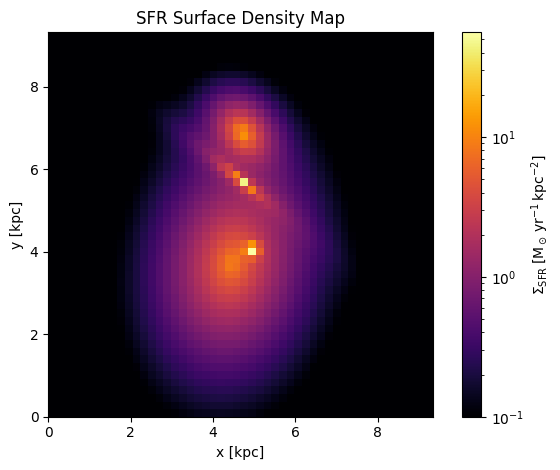

In [82]:
ny, nx = 50, 50

# Grid setup
y, x = np.mgrid[0:ny, 0:nx]

pixel_area_kpc2 = (pixel_scale * kpc_per_arcsec)**2

# --- CONVERT TO SFR SURFACE DENSITY ---
sfr_surface_density_map = sfr_map / pixel_area_kpc2  # M_sun / yr / kpc^2

# --- PLOT ---
extent = [0, nx * kpc_per_pixel, 0, ny * kpc_per_pixel]  # extent in kpc

plt.imshow(sfr_surface_density_map, origin='lower', extent=extent, cmap='inferno', norm='log', vmin=1e-1)
plt.colorbar(label='$\Sigma_{\mathrm{SFR}} \;[\mathrm{M}_\odot\,\mathrm{yr}^{-1}\,\mathrm{kpc}^{-2}]$')
plt.xlabel('x [kpc]')
plt.ylabel('y [kpc]')
plt.title('SFR Surface Density Map')
plt.tight_layout()
plt.show()

### Tacconi+ gas mass

In [ ]:
# function to calculate the SFMS from Speagle+ (2014)

def log_sfms_speagle(t, logM_star):
    """
    Speagle+ (2014) SFMS: log SFR = a(t) * logM_star + b(t)

    Inputs:
        t           : cosmic time in Gyr (can be scalar or numpy array)
        logM_star   : log10 stellar mass (same shape as t)

    Output:
        log10 SFR
    """
    import numpy as np

    a = 0.84 - 0.026 * t
    b = -6.51 + 0.11 * t

    return a * logM_star + b

In [84]:
# function to calculate the gas mass from Tacconi+ (2018)

def log_mu_gas_tacconi(z,SFR, logM_star, sfms = 'speagle'):
    A = 0.06 #+-0.2
    B = -3.33 #+-0.2
    C = 0.51 #+-0.03
    D = -0.41 #+-0.03
    F = 0.65 #+- 0.05
    if sfms == 'will':
        log_sSFR_ms = log_sfms_will(np.array([np.array(z),np.array(logM_star)]).astype(float))
    elif sfms == 'speagle':
        t = cosmo.age(z).value
        log_sSFR_ms = log_sfms_speagle(t,np.array(logM_star).astype(float)) - logM_star
    elif sfms == 'clarke':
        log_sSFR_ms = log_sfms_clarke(np.array(logM_star).astype(float)) - logM_star
    log_sSFR = np.log10(SFR) - logM_star

    return A + B*(np.log10(1+z) - F)**2 + C*(log_sSFR - log_sSFR_ms) + D*(logM_star-10.7)

# speagle_ssfrms = 4.1 * 10 ** (-7)

In [85]:
# Computing gas mass fraction for each component via above formulae
gas_surface_density_map = np.zeros((ny, nx))

for cname in cnames:
    p = params_dict[cname]['sersic_params'][filter_name]
    sersic = Sersic2D(amplitude=1,
                    r_eff=p['r_eff']['med'],
                    n=p['n']['med'],
                    # y, x, and theta flipped to realign
                    y_0=p['xc']['med'],
                    x_0=p['yc']['med'],
                    ellip=p['ellip']['med'],
                    theta=-p['theta']['med'])
    sfrdata = params_dict[cname]['prospector']['sfr_data']
    sfr = sfrdata['sfr_10_Myr']
    logM_star = params_dict[cname]['prospector']['log_msun']
    M_star = 10 ** logM_star
    log_mu_gas = log_mu_gas_tacconi(5.3, sfr, logM_star)
    mu_gas = 10 ** log_mu_gas
    print("Component:", cname)
    print("Mu Gas:", mu_gas)
    print("######################")
    profile = sersic(x, y)
    profile /= profile.sum()  # normalize
    Σ_star = np.transpose(profile * M_star / pixel_area_kpc2)  # M☉ / kpc²
    Σ_gas = Σ_star * mu_gas  # M☉ / kpc²

    gas_surface_density_map += Σ_gas

    # # Combine into sfr map; transpose to realign
    # sfr_map += np.transpose((profile * mu_gas))

Component: Core
Mu Gas: 0.5895789263235209
######################
Component: Point Source
Mu Gas: 2.2375144045284805
######################
Component: Minor Clump
Mu Gas: 2.4182405612782545
######################
Component: Major Clump
Mu Gas: 3.031574911428876
######################


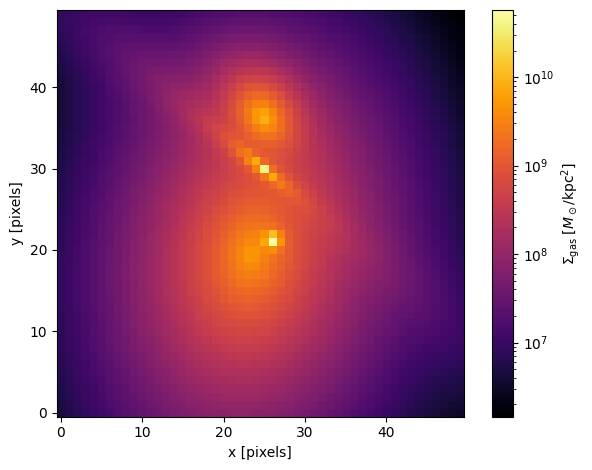

In [86]:
# Inputs
positions = (25,25)          # centre of the apertures
ellip = 0.43 #0.43          # ellipticity = (1 - b/a); 
r_eff = 100 # 9.51            # effective radius in pixels
a = r_eff               # semi-major axis
b_a = 1 - ellip  # semi-minor axis b = (ellip + 1) * a
theta = 1.53                # theta in radians


# Semi-major axis lengths (in pixels)
a_vals = np.linspace(0.5, 50, 100)

gas_masses = []

for a in a_vals:  # in pixels
    aperture = EllipticalAperture(positions, a, a * b_a, theta)
    phot_table = aperture_photometry(gas_surface_density_map, aperture)
    gas_mass = phot_table['aperture_sum'][0] * pixel_area_kpc2  # sum over Σ × area
    gas_masses.append(gas_mass)


plt.imshow(gas_surface_density_map, origin='lower', cmap='inferno', norm='log')  # or norm=LogNorm() if needed
plt.colorbar(label=r'$\Sigma_{\mathrm{gas}}$ [$M_\odot$/kpc$^2$]')
plt.xlabel('x [pixels]')
plt.ylabel('y [pixels]')
plt.tight_layout()

# for aperture in apertures:
#     aperture.plot(color='white', lw=1)

plt.show()


Initial mass distribution plotting:

<>:8: SyntaxWarning: invalid escape sequence '\o'
<>:8: SyntaxWarning: invalid escape sequence '\o'
C:\Users\kings\AppData\Local\Temp\ipykernel_20880\1675929817.py:8: SyntaxWarning: invalid escape sequence '\o'
  plt.ylabel('Total mass enclosed (M$_\odot$)')


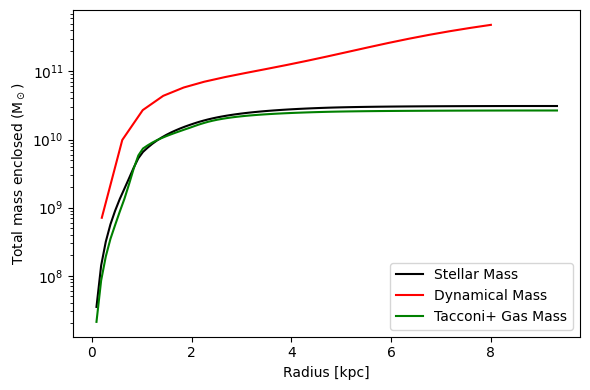

(Prospector's Mass: 3.10e+10 M☉)
Total Stellar Mass: 3.10e+10 M☉
Total Gas Mass: 2.67e+10 M☉
Total Dynamical Mass: 4.81e+11 M☉
Missing Mass: 4.24e+11 M☉


In [87]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(a_vals_kpc, masses, color='black')
plt.plot(dyn_radius_kpc, dyn_mass_msun, color='red')
plt.plot(a_vals_kpc, gas_masses, color='green')
plt.xlabel(r'Radius [kpc]')
plt.ylabel('Total mass enclosed (M$_\odot$)')
plt.yscale('log')
plt.legend(['Stellar Mass', 'Dynamical Mass', 'Tacconi+ Gas Mass'])
# plt.grid(True)
plt.tight_layout()
plt.show()

print(f"(Prospector's Mass: {prosp_mass:.2e} M☉)")
print(f"Total Stellar Mass: {np.max(masses):.2e} M☉")
print(f"Total Gas Mass: {np.max(gas_masses):.2e} M☉")
print(f"Total Dynamical Mass: {np.max(dyn_mass_msun[-1]):.2e} M☉")
print(f"Missing Mass: {np.max(dyn_mass_msun[-1]) - np.max(masses) - np.max(gas_masses):.2e} M☉")


## Incorporating Uncertainties
- Want to iterate over F356W's 4comp .asdf, using np.randomchoice to select the param values for Sersic2D
-- NB Component "1" needs manually-set theta/reff/ellip
- Then to iterate over Prospector's sampled mass values, using randomchoice to pick one out
- Then to calculate the SFR for that mass value...
- Then to combine them into a mass/sfr map
- ...and repeat 1000 times, and take the median map(s)...

In [88]:
# Need to call in each pysersic posterior's sample space (from asdf)
# and each prospector's posterior sample space

# F356W data path:
sersic_path = r"D:\Programming\Cambridge\Enso Data\Output\4compSVI_f356w.asdf"
# Prospect Samples:
# prosp_path = r"D:\Programming\Cambridge\Enso Data\sample_data.asdf"
prosp_path = r"D:\Programming\Cambridge\Enso Data\sfh_sample_data.asdf"

sample_dict = {}
param_names = ['flux', 'r_eff', 'n', 'ellip', 'theta', 'xc', 'yc']

# with asdf.open(sersic_path) as af:
#     # Get the posterior samples for each component
#     for i, cname in enumerate(cnames):
#         # Get the posterior samples for the current component
#         posterior_samples = af['posterior']

with asdf.open(sersic_path) as af:
    asdf_dict = copy.deepcopy(af.tree)
    for i, cname in enumerate(cnames):
        sample_dict[cname] = {}  # <- create per-component dict
        fdict = sample_dict[cname]
        for param in param_names:
            if i == 1 and param == 'n':
                fdict[param] = np.full(1000, 1)
            elif i == 1 and param == 'r_eff':
                fdict[param] = np.full(1000, 0.5)
            elif i == 1 and param in ('ellip', 'theta'):
                fdict[param] = np.full(1000, 0.0)
            else:
                key = f'{param}_{i}'
                if key in af['posterior']:
                    fdict[param] = asdf_dict['posterior'][key].flatten()
                else:
                    fdict[param] = {'med': None}  # or skip/raise if key missing

with asdf.open(prosp_path) as af:
    asdf_dict = copy.deepcopy(af.tree)
    for i in cnames:
        # logmass taken from integrated sfh;
        # 1000x log m_star
        sample_dict[i]['logMstar_samples'] = asdf_dict[i]['logsfhmass']
        # 1000x Mstar/yr
        sample_dict[i]['sfr_samples'] = asdf_dict[i]['sfr_10_Myr']
        sample_dict[i]['sm'] = asdf_dict[i]['sm']
        sample_dict[i]['smlogmass'] = np.log10((10**sample_dict[i]['logMstar_samples'])*sample_dict[i]['sm'])


C:\Users\kings\AppData\Roaming\Python\Python312\site-packages\asdf\_asdf.py:388: AsdfPackageVersionWarning: File 'file:///D:/Programming/Cambridge/Enso%20Data/sfh_sample_data.asdf' was created with extension URI 'asdf://asdf-format.org/core/extensions/core-1.6.0' (from package asdf==4.1.0), but older package (asdf==3.5.0) is installed.
  warnings.warn(msg, AsdfPackageVersionWarning)


### Latex Results Table
(brief tangent for thesis plotting)

In [89]:
# Containers for table values
logMstar_vals = []
sfr_vals = []
sm_vals = []
smlogmass_vals = []

def median_pm(samples):
    median = np.percentile(samples, 50)
    lower = median - np.percentile(samples, 16)
    upper = np.percentile(samples, 84) - median
    return median, lower, upper

def median_and_symerr(samples):
        median = np.percentile(samples, 50)
        lower = median - np.percentile(samples, 16)
        upper = np.percentile(samples, 84) - median
        symerr = (lower + upper) / 2
        return median, symerr

for name in cnames:
    post = sample_dict[name]

    logM, logM_err = median_and_symerr(post['logMstar_samples'])
    sfr, sfr_low, sfr_upp = median_pm(post['sfr_samples'])
    sm, sm_err = median_and_symerr(post['sm'])
    smlog, smlog_err = median_and_symerr(post['smlogmass'])

    logMstar_vals.append((logM, logM_err))
    sfr_vals.append((sfr, sfr_low, sfr_upp))
    sm_vals.append((sm, sm_err))
    smlogmass_vals.append((smlog, smlog_err))

In [90]:
# Compute totals from samples
logM_total_samples = np.log10(np.sum([10**np.array(sample_dict[n]['logMstar_samples']) for n in cnames], axis=0))
sfr_total_samples = np.sum([np.array(sample_dict[n]['sfr_samples']) for n in cnames], axis=0)
smlog_total_samples = np.log10(np.sum([10**np.array(sample_dict[n]['smlogmass']) for n in cnames], axis=0))

def median_and_symerr(samples):
    median = np.percentile(samples, 50)
    lower = median - np.percentile(samples, 16)
    upper = np.percentile(samples, 84) - median
    return median, (lower + upper) / 2


sfr_total, sfr_lower, sfr_upper = median_pm(sfr_total_samples)
# print(f"Total SFR: {sfr_total:.2f} (+{sfr_upper:.2f}/-{sfr_lower:.2f}) M☉/yr")

logM_total, logM_total_err = median_and_symerr(logM_total_samples)
sfr_total, sfr_total_err = median_and_symerr(sfr_total_samples)
smlog_total, smlog_total_err = median_and_symerr(smlog_total_samples)

# Build LaTeX table
latex_table = r"""\begin{table}[ht]
\centering
\textbf{Stellar and Gas Properties of Galaxy Components}
\vspace{0.5em}
\begin{tabular}{lcccc}
\hline
Component & $\log(M_*/M_\odot)$ & SM Factor & SFR [$M_\odot$/yr] & $\log(M_{\mathrm{surv}}/M_\odot)$ \\
\hline
"""

for i, name in enumerate(cnames):
    logM, logM_err = logMstar_vals[i]
    sm, sm_err = sm_vals[i]
    sfr, sfr_low, sfr_upp = sfr_vals[i]
    smlog, smlog_err = smlogmass_vals[i]

    latex_table += (
        f"{name} & "
        f"${logM:.2f} \\pm {logM_err:.2f}$ & "
        f"${sm:.2f} \\pm {sm_err:.2f}$ & "
        f"${sfr:.2f}"
        "^{+"
        f"{sfr_upp:.2f}"
        "}_{-"
        f"{sfr_low:.2f}"
        "}$ & "
        f"${smlog:.2f} \\pm {smlog_err:.2f}$ \\\\\n"
    )

latex_table += r"\hline" + "\n"
latex_table += (
    f"Total & "
    f"${logM_total:.2f} \\pm {logM_total_err:.2f}$ & "
    f"$-$ & "
    f"${sfr_total:.2f}"
    "^{+"
    f"{sfr_upper:.2f}"
    "}_{-"
    f"{sfr_lower:.2f}"
    "}$ & "
    f"${smlog_total:.2f} \\pm {smlog_total_err:.2f}$ \\\\\n"
)

latex_table += r"""\hline
\end{tabular}
\caption{Posterior median values and symmetric 1$\sigma$ uncertainties for the log formed stellar mass, stellar mass survival factor (SM Factor), star formation rate (SFR), and log surviving stellar mass for each galaxy component and the total.}
\end{table}
"""

print(latex_table)


\begin{table}[ht]
\centering
\textbf{Stellar and Gas Properties of Galaxy Components}
\vspace{0.5em}
\begin{tabular}{lcccc}
\hline
Component & $\log(M_*/M_\odot)$ & SM Factor & SFR [$M_\odot$/yr] & $\log(M_{\mathrm{surv}}/M_\odot)$ \\
\hline
Core & $10.47 \pm 0.13$ & $0.71 \pm 0.03$ & $44.14^{+28.17}_{-23.38}$ & $10.32 \pm 0.12$ \\
Point Source & $9.03 \pm 0.23$ & $0.72 \pm 0.04$ & $2.96^{+2.35}_{-1.69}$ & $8.88 \pm 0.22$ \\
Minor Clump & $9.08 \pm 0.40$ & $0.74 \pm 0.06$ & $7.85^{+8.67}_{-3.56}$ & $8.94 \pm 0.38$ \\
Major Clump & $8.86 \pm 0.27$ & $0.84 \pm 0.09$ & $13.23^{+40.26}_{-8.76}$ & $8.79 \pm 0.23$ \\
\hline
Total & $10.52 \pm 0.12$ & $-$ & $82.53^{+41.32}_{-32.05}$ & $10.38 \pm 0.11$ \\
\hline
\end{tabular}
\caption{Posterior median values and symmetric 1$\sigma$ uncertainties for the log formed stellar mass, stellar mass survival factor (SM Factor), star formation rate (SFR), and log surviving stellar mass for each galaxy component and the total.}
\end{table}



In [92]:
# loading in variables for comparison and calculations

core_mass = np.median(sample_dict['Core']['logMstar_samples'])
point_source_mass = np.median(sample_dict['Point Source']['logMstar_samples'])
minor_clump_mass = np.median(sample_dict['Minor Clump']['logMstar_samples'])
major_clump_mass = np.median(sample_dict['Major Clump']['logMstar_samples'])
total_mass = (10 ** core_mass) + (10 ** point_source_mass) + (10 ** minor_clump_mass) + (10 ** major_clump_mass)
total_logmass = np.log10(total_mass)

core_final = np.median(sample_dict['Core']['smlogmass'])
point_source_final = np.median(sample_dict['Point Source']['smlogmass'])
minor_clump_final = np.median(sample_dict['Minor Clump']['smlogmass'])
major_clump_final = np.median(sample_dict['Major Clump']['smlogmass'])


final_mass = (10**core_final) + (10**point_source_final) + (10**minor_clump_final) + (10**major_clump_final)
total_final = np.log10(final_mass)
print("Core median sm factor:", np.median(sample_dict['Core']['sm']))
print("Core integrated mass:", core_mass)
print("Core final logmass:", core_final)
print("Point Source logmass:", point_source_final)
print("Minor Clump logmass:", minor_clump_final)
print("Major Clump logmass:", major_clump_final)
print("Total logmass, incorporating SM factor:", total_final)
print("i.e., Total mass:", format((10**total_final), '2e'))


Core median sm factor: 0.7124410376227948
Core integrated mass: 10.469333638537117
Core final logmass: 10.317726620150193
Point Source logmass: 8.880516960390079
Minor Clump logmass: 8.944782060342774
Major Clump logmass: 8.792496967215822
Total logmass, incorporating SM factor: 10.36256008956581
i.e., Total mass: 2.304412e+10


In [97]:
# generate 1000 50x50 empty maps
N = 1000
ny, nx = 50, 50
y, x = np.mgrid[0:ny, 0:nx]
mass_maps = np.zeros((N, ny, nx))
sfr_maps = np.zeros((N, ny, nx))
# Tacconi gas fractions
mu_gases = np.zeros((N, ny, nx))
# Surface densities in Msun / kpc^2
mass_srfdens = np.zeros((N, ny, nx))
gas_srfdens = np.zeros((N, ny, nx))
gas_check = {}
gas_total = 0

# loop over components and samples, saving maps to dicts

for cname in cnames:
    sam = sample_dict[cname]
    sample_dict[cname]['gas_mass'] = [] 
    # NB COORD SWAP for diff plotting
    gas_check[cname] = {'mu_gas': [],
                        'sfr': []}  
    # Random but corresponding indices to sample
    indices = np.random.choice(1000, size=1000, replace=True)
    for i, idx in enumerate(indices):
        # Extract sersic vals for sample no. 'idx'
        r_eff = sam['r_eff'][idx]
        n = sam['n'][idx]
        ellip = sam['ellip'][idx]
        theta = sam['theta'][idx]
        y0 = sam['xc'][idx]
        x0 = sam['yc'][idx]

        # Extract a mass for this index
        log_mass = sam['smlogmass'][idx] # sam['logMstar_samples'][idx]
        mass = 10**log_mass
        
        # SFR (Mstar / yr)
        sfr = sam['sfr_samples'][idx]
        # Gas fraction
        log_mu_gas = log_mu_gas_tacconi(5.3, sfr, log_mass)
        mu_gas = 10 ** log_mu_gas
        mu_gases[i] += mu_gas
        gas_check[cname]['sfr'].append(sfr)
        gas_check[cname]['mu_gas'].append(mu_gas)
        sam['gas_mass'].append(mu_gas * mass)

        # Create model
        sersic = Sersic2D(amplitude=1, r_eff=r_eff, n=n,
                          ellip=ellip, theta=-theta,
                          x_0=x0, y_0=y0)
        profile = sersic(x, y)
        profile /= profile.sum()

        # Scale light profiles to mass/sfr
        mass_maps[i] += np.transpose(profile * mass)
        sfr_maps[i] += np.transpose(profile * sfr)

        # Calculate stellar & gas surface densities (for current sample)
        Σ_star = np.transpose(profile * mass / pixel_area_kpc2)  # M☉ / kpc²
        Σ_gas = Σ_star * mu_gas  # M☉ / kpc²
        mass_srfdens[i] += Σ_star
        gas_srfdens[i] += Σ_gas

    sfr_total, sfr_lower, sfr_upper = median_pm(gas_check[cname]['sfr'])

    print(f"{cname} gas fraction: {np.median(gas_check[cname]['mu_gas']):.2f}")
    print(f"{cname} Simple Gas Mass: {np.median(sam['gas_mass']):.2e} M☉")
    print(f"{cname} SFR: {sfr_total:.2f} M☉/yr")
    print(f"{cname} SFR -: {sfr_lower:.2f} M☉/yr")
    print(f"{cname} SFR +: {sfr_upper:.2f} M☉/yr")

# print(f"Total SFR: {sfr_total:.2f} (+{sfr_upper:.2f}/-{sfr_lower:.2f}) M☉/yr")

    gas_total += np.median(sam['gas_mass'])
    # sam[cname]['gas_mass'] = gas_check[cname]['mu_gas']*(10**sam['smlogmass'])


Core gas fraction: 0.84
Core Simple Gas Mass: 2.02e+10 M☉
Core SFR: 45.63 M☉/yr
Core SFR -: 24.58 M☉/yr
Core SFR +: 27.78 M☉/yr
Point Source gas fraction: 3.40
Point Source Simple Gas Mass: 2.61e+09 M☉
Point Source SFR: 2.89 M☉/yr
Point Source SFR -: 1.56 M☉/yr
Point Source SFR +: 2.24 M☉/yr
Minor Clump gas fraction: 5.32
Minor Clump Simple Gas Mass: 4.44e+09 M☉
Minor Clump SFR: 8.06 M☉/yr
Minor Clump SFR -: 3.77 M☉/yr
Minor Clump SFR +: 9.62 M☉/yr
Major Clump gas fraction: 7.18
Major Clump Simple Gas Mass: 5.15e+09 M☉
Major Clump SFR: 12.15 M☉/yr
Major Clump SFR -: 7.94 M☉/yr
Major Clump SFR +: 40.07 M☉/yr


In [94]:
np.log10(gas_total)

np.float64(10.515599105624263)

Saving median, upper and lower quantile maps:

In [95]:
mass_map_median = np.median(mass_maps, axis=0)
mass_map_lower = np.percentile(mass_maps, 16, axis=0)
mass_map_upper = np.percentile(mass_maps, 84, axis=0)

sfr_map_median = np.median(sfr_maps, axis=0)
sfr_map_lower = np.percentile(sfr_maps, 16, axis=0)
sfr_map_upper = np.percentile(sfr_maps, 84, axis=0)

mass_srf_den_median = np.median(mass_srfdens, axis=0)
mass_srf_den_lower = np.percentile(mass_srfdens, 16, axis=0)
mass_srf_den_upper = np.percentile(mass_srfdens, 84, axis=0)

gas_srf_den_median = np.median(gas_srfdens, axis=0)
gas_srf_den_lower = np.percentile(gas_srfdens, 16, axis=0)
gas_srf_den_upper = np.percentile(gas_srfdens, 84, axis=0)


Plotting median stellar mass surface density map:

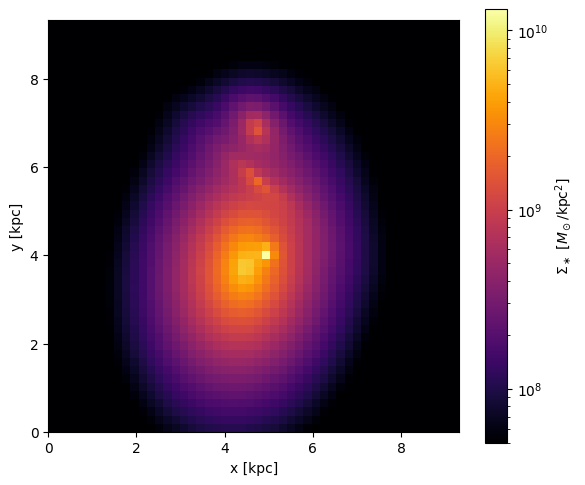

In [96]:
extent = [0, nx * kpc_per_pixel, 0, ny * kpc_per_pixel]  # extent in kpc

plt.figure(figsize=(6, 5))
plt.imshow(mass_srf_den_median, origin='lower', cmap='inferno', extent=extent, norm='log', vmin=5e7)  # or norm=LogNorm() if needed
plt.colorbar(label=r'$\Sigma_\ast$ [$M_\odot$/kpc$^2$]')
# plt.title('Stellar Mass Surface Density')
plt.xlabel('x [kpc]')
plt.ylabel('y [kpc]')
plt.tight_layout()
# plt.savefig('map_smstellarsfcden', dpi=300)
plt.show()

Plotting median SFR surface density:

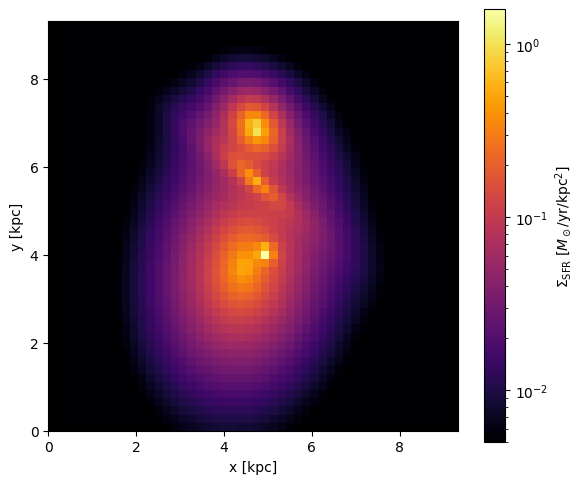

In [98]:
extent = [0, nx * kpc_per_pixel, 0, ny * kpc_per_pixel]  # extent in kpc

plt.figure(figsize=(6, 5))
plt.imshow(sfr_map_median, origin='lower', cmap='inferno', extent=extent, norm='log', vmin=5e-3)  # or norm=LogNorm() if needed
plt.colorbar(label=r'$\Sigma_{\mathrm{SFR}}$ [$M_\odot$/yr/kpc$^2$]')
# plt.title('Stellar Mass Surface Density')
plt.xlabel('x [kpc]')
plt.ylabel('y [kpc]')
plt.tight_layout()
# plt.savefig('map_SFRsfcden', dpi=300)
plt.show()

Plotting median gas surface density:

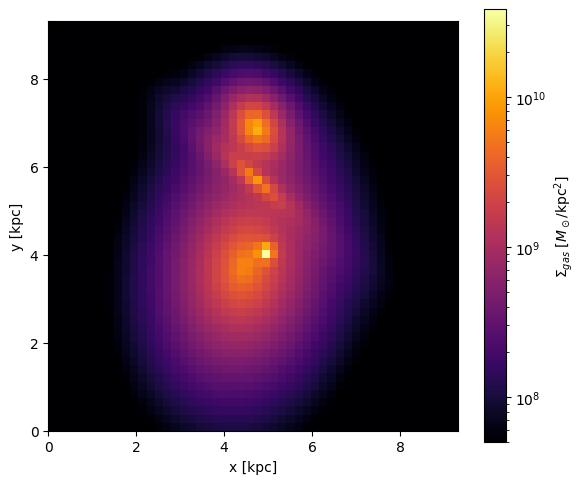

In [99]:
extent = [0, nx * kpc_per_pixel, 0, ny * kpc_per_pixel]  # extent in kpc

plt.figure(figsize=(6, 5))
plt.imshow(gas_srf_den_median, origin='lower', cmap='inferno', extent=extent, norm='log', vmin=5e7)  # or norm=LogNorm() if needed
plt.colorbar(label=r'$\Sigma_{gas}$ [$M_\odot$/kpc$^2$]')
# plt.title('Stellar Mass Surface Density')
plt.xlabel('x [kpc]')
plt.ylabel('y [kpc]')
plt.tight_layout()
# plt.savefig('map_smgassfcden', dpi=300)
plt.show()

Preliminary full radial mass profile of stellar and dynamical mass:

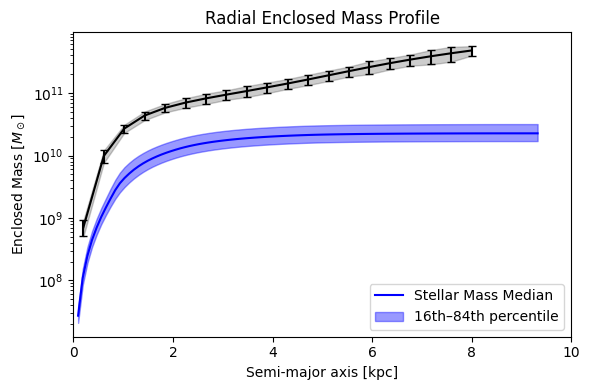

In [100]:
import numpy as np
import matplotlib.pyplot as plt
from photutils.aperture import EllipticalAperture, aperture_photometry

# --- Input maps (replace with your actual arrays) ---
maps = {
    'median': mass_map_median,
    'lower': mass_map_lower,
    'upper': mass_map_upper
}

# --- Elliptical aperture settings ---
positions = (25,25)  # centre in pixels
ellip = 0.43
b_a = 1 - ellip
theta = 1.53  # in radians
a_vals = np.linspace(0.5, 50, 100)  # semi-major axis values in pixels

# --- Aperture photometry ---
aperture_sums = {key: [] for key in maps}

for a in a_vals:
    aperture = EllipticalAperture(positions, a, a * b_a, theta)
    for key, map_data in maps.items():
        phot = aperture_photometry(map_data, aperture)
        aperture_sums[key].append(phot['aperture_sum'][0])

# --- Plot results ---
# a_vals_kpc = a_vals * kpc_per_pixel  # optional: convert to kpc if you know pixel scale

plt.figure(figsize=(6, 4))

# plt.plot(dyn_radius_kpc, dyn_mass_msun, color='black', linestyle=':', label='Dynamical Mass')
plt.errorbar(dyn_radius_kpc, dyn_mass_msun, yerr=dyn_mass_unc, fmt='-', color='black', capsize=3)
plt.plot(a_vals_kpc, aperture_sums['median'], color='blue', label='Stellar Mass Median')
plt.fill_between(dyn_radius_kpc,
                 dyn_mass_msun - dyn_mass_unc,
                 dyn_mass_msun + dyn_mass_unc,
                 color='black', alpha=0.2)

plt.fill_between(a_vals_kpc, aperture_sums['lower'], aperture_sums['upper'],
                 color='blue', alpha=0.4, label='16th–84th percentile')
plt.xlabel('Semi-major axis [kpc]')
plt.ylabel(r'Enclosed Mass [$M_\odot$]')  # or SFR units
plt.title('Radial Enclosed Mass Profile')
plt.xlim(0, 10)
plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.show()


In [101]:
np.max(aperture_sums['median'])

np.float64(22660980225.058224)

Full map, with uncertainties and labels:

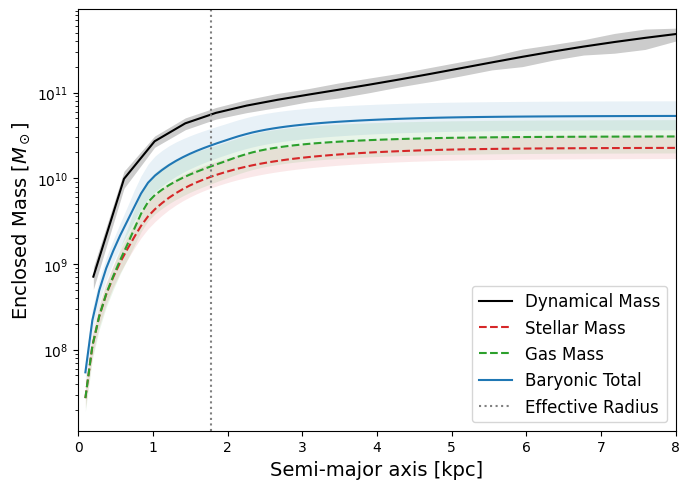

In [102]:
# Parameters
positions = (25,25)
ellip = 0.43
b_a = 1 - ellip
theta = 1.53
a_vals = np.linspace(0.5, 50, 100)  # semi-major axis in pixels

# Mass maps (stellar, gas, total baryonic)
mass_dict = {
    'stellar': {
        'median': mass_srf_den_median,
        'lower': mass_srf_den_lower,
        'upper': mass_srf_den_upper
    },
    'gas': {
        'median': gas_srf_den_median,
        'lower': gas_srf_den_lower,
        'upper': gas_srf_den_upper
    }
}

# Add baryonic mass
mass_dict['baryonic'] = {
    key: mass_dict['stellar'][key] + mass_dict['gas'][key]
    for key in ['median', 'lower', 'upper']
}

# Enclosed mass containers
enclosed_mass = {comp: {'median': [], 'lower': [], 'upper': []} for comp in mass_dict}

# Photometry loop
for a in a_vals:
    aperture = EllipticalAperture(positions, a, a * b_a, theta)
    for comp in mass_dict:
        for key in ['median', 'lower', 'upper']:
            phot = aperture_photometry(mass_dict[comp][key], aperture)
            enclosed_mass[comp][key].append(phot['aperture_sum'][0] * pixel_area_kpc2)  # Convert to M☉

# Convert to arrays
for comp in enclosed_mass:
    for key in enclosed_mass[comp]:
        enclosed_mass[comp][key] = np.array(enclosed_mass[comp][key])

# Optional: physical scale
# pixel_scale_kpc = 0.32  # update if different
# radius_kpc = a_vals * pixel_scale_kpc

# Your dynamical mass data
# radius_kpc = [...]         # already defined here
# dyn_mass_msun = [...]      # your precomputed dynamical mass profile
dyn_bumped = dyn_mass_msun #* 2.70
# Plot
plt.figure(figsize=(7, 5))

# plt.plot(dyn_radius_kpc, dyn_mass_msun, color='black', label='Dynamical Mass')
plt.plot(dyn_radius_kpc, dyn_bumped, color='black', label='Dynamical Mass')
plt.fill_between(dyn_radius_kpc,
                 dyn_mass_msun - dyn_mass_unc,
                 dyn_mass_msun + dyn_mass_unc,
                 color='black', alpha=0.2,  linewidth=0)

plt.plot(a_vals_kpc, enclosed_mass['stellar']['median'], color='tab:red', label='Stellar Mass',linestyle='--')
plt.fill_between(a_vals_kpc, enclosed_mass['stellar']['lower'], enclosed_mass['stellar']['upper'], color='tab:red', alpha=0.1, linewidth=0)

plt.plot(a_vals_kpc, enclosed_mass['gas']['median'], color='tab:green', label='Gas Mass', linestyle='--')
plt.fill_between(a_vals_kpc, enclosed_mass['gas']['lower'], enclosed_mass['gas']['upper'], color='tab:green', alpha=0.1, linewidth=0)

plt.plot(a_vals_kpc, enclosed_mass['baryonic']['median'], color='tab:blue', label='Baryonic Total', linestyle='-')
plt.fill_between(a_vals_kpc, enclosed_mass['baryonic']['lower'], enclosed_mass['baryonic']['upper'], color='tab:blue', alpha=0.1,  linewidth=0)

r_eff_kpc = 9.51 * kpc_per_pixel  # effective radius in kpc
plt.axvline(r_eff_kpc, color='gray', linestyle=':', label='Effective Radius')

plt.xlabel('Semi-major axis [kpc]', fontsize=14)
plt.ylabel(r'Enclosed Mass [$M_\odot$]', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=10)
# plt.title('Radial Mass Profiles')
plt.xlim(0, 8) 
plt.legend(fontsize=12)
plt.yscale('log')
plt.tight_layout()
# plt.savefig('radial_mass_profiles.pdf', dpi=300)
plt.show()


In [103]:
np.median(kpc_per_pixel) * 2 * 0.145 #9.77

np.float64(0.05408459043295882)

In [104]:

def half_mass_radius(r_kpc, M_enclosed):
    """
    Return the radius (semi-major axis) at which the enclosed mass reaches 50% of the total.
    r_kpc and M_enclosed must be same-length 1D arrays.
    """
    r = np.asarray(r_kpc)
    M = np.asarray(M_enclosed)

    # Ensure sorted by radius (should already be, but just in case)
    sort = np.argsort(r)
    r = r[sort]
    M = M[sort]

    # Enforce monotonic non-decreasing cumulative mass (guards against tiny numerical dips)
    M = np.maximum.accumulate(M)

    # Normalized cumulative fraction
    frac = M / M[-1]

    # Interpolate radius where fraction = 0.5
    return np.interp(0.5, frac, r)

# --- choose component ---
comp = 'stellar'  # or 'baryonic', 'gas'

r_half_med = half_mass_radius(a_vals_kpc, enclosed_mass[comp]['median'])
r_half_low = half_mass_radius(a_vals_kpc, enclosed_mass[comp]['upper'])  # more mass -> smaller radius
r_half_up  = half_mass_radius(a_vals_kpc, enclosed_mass[comp]['lower'])  # less mass -> larger radius

print(f"{comp.capitalize()} half-mass radius (median): {r_half_med:.3f} kpc")
print(f"{comp.capitalize()} half-mass radius 68% range: [{r_half_low:.3f}, {r_half_up:.3f}] kpc")

# Optional: circularized half-mass radius (use if you need circular radius)
b_a = 1 - ellip  # from your setup
r_half_circ_med = r_half_med * np.sqrt(b_a)
print(f"Circularized half-mass radius (median): {r_half_circ_med:.3f} kpc")


Stellar half-mass radius (median): 1.901 kpc
Stellar half-mass radius 68% range: [1.869, 1.921] kpc
Circularized half-mass radius (median): 1.436 kpc


Checking values:

In [105]:

# print(f"(Prospector's Mass: {prosp_mass:.2e} M☉)")
# print(f"Total Stellar Mass: {np.max(masses):.2e} M☉")
# print(f"Total Gas Mass: {np.max(gas_masses):.2e} M☉")
# print(f"Total Dynamical Mass: {np.max(dyn_mass_msun[-1]):.2e} M☉")
# print(f"Missing Mass: {np.max(dyn_mass_msun[-1]) - np.max(masses) - np.max(gas_masses):.2e} M☉")
# Extract values from the dictionary
stellar_median = np.max(enclosed_mass['stellar']['median'])
stellar_lower = np.max(enclosed_mass['stellar']['lower'])
stellar_upper = np.max(enclosed_mass['stellar']['upper'])

gas_median = np.max(enclosed_mass['gas']['median'])
gas_lower = np.max(enclosed_mass['gas']['lower'])
gas_upper = np.max(enclosed_mass['gas']['upper'])

dyn_mass = np.max(dyn_mass_msun)
missing_mass = dyn_mass - stellar_median - gas_median

# Print in your style
print(f"Total Stellar Mass: {stellar_median:.2e} M☉ (+{stellar_upper - stellar_median:.2e}/-{stellar_median - stellar_lower:.2e})")
print(f"Total Gas Mass: {gas_median:.2e} M☉ (+{gas_upper - gas_median:.2e}/-{gas_median - gas_lower:.2e})")
print(f"Total Dynamical Mass: {dyn_mass:.2e} M☉")
print(f"Missing Mass: {missing_mass:.2e} M☉")
print(f"Non-baryonic Fraction: {missing_mass / dyn_mass:.2%}")


Total Stellar Mass: 2.27e+10 M☉ (+9.24e+09/-5.64e+09)
Total Gas Mass: 3.08e+10 M☉ (+1.76e+10/-1.10e+10)
Total Dynamical Mass: 4.81e+11 M☉
Missing Mass: 4.28e+11 M☉
Non-baryonic Fraction: 88.89%


### Total DMF with R plot

In [106]:
# interpolate to match list lengths
from scipy.interpolate import interp1d

# Create interpolation function from lola's data
dyn_interp = interp1d(dyn_radius_kpc, dyn_mass_msun, kind='linear', bounds_error=False, fill_value='extrapolate')

# Interpolate to match your 100-point a_vals_kpc
dyn_mass_interp = dyn_interp(a_vals_kpc)


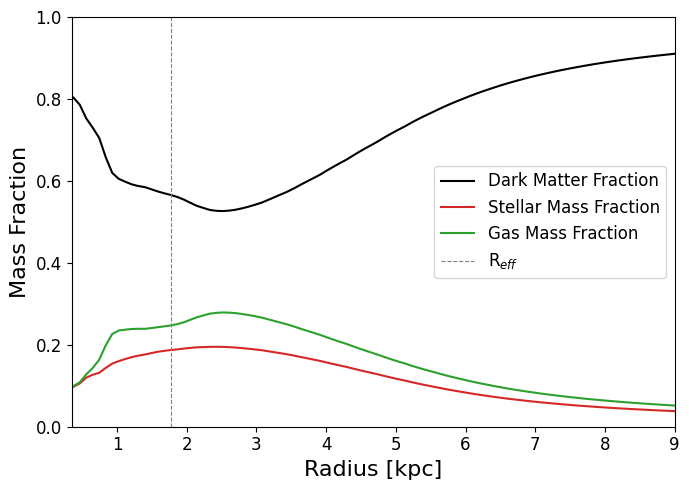

In [107]:
# Get fractional values as fn of radius
stellar_frac = enclosed_mass['stellar']['median'] / dyn_mass_interp
gas_frac = enclosed_mass['gas']['median'] / dyn_mass_interp
dm_frac = 1 - stellar_frac - gas_frac
r_eff_kpc = 9.51 * kpc_per_pixel  # effective radius in kpc

# Plot
plt.figure(figsize=(7, 5))
plt.plot(a_vals_kpc, dm_frac, label='Dark Matter Fraction', color='black')
# plt.plot(a_vals_kpc, stellar_frac+gas_frac, label='Baryonic Mass Fraction', color='tab:blue')
plt.plot(a_vals_kpc, stellar_frac, label='Stellar Mass Fraction', color='tab:red')
plt.plot(a_vals_kpc, gas_frac, label='Gas Mass Fraction', color='tab:green')

# Formatting
plt.xlabel('Radius [kpc]', fontsize=16)
plt.ylabel('Mass Fraction', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=12)
# plt.title('Mass Fractions vs Radius')
plt.ylim(0, 1)
plt.xlim(0.35,9)
plt.axvline(r_eff_kpc, color='gray', linestyle='--', linewidth=0.8, label='R$_{eff}$')
# plt.axhline(1, color='gray', linestyle='--', linewidth=0.8)
plt.legend(fontsize=12)
# plt.grid(True)
plt.tight_layout()
# plt.savefig('mass_fractions.pdf', dpi=300)
plt.show()


Adding uncertainties:

In [108]:
import numpy as np

# 1) make sure dyn is on same grid
dyn_mass_interp      = np.interp(a_vals_kpc, dyn_radius_kpc, dyn_mass_msun)
dyn_mass_unc_interp  = np.interp(a_vals_kpc, dyn_radius_kpc, dyn_mass_unc)

# 2) medians
S = enclosed_mass['stellar']['median']
G = enclosed_mass['gas']['median']
D = dyn_mass_interp

# 3) 1-sigma from 16-84 bands (symmetric approx)
sigma_S = 0.5 * (enclosed_mass['stellar']['upper'] - enclosed_mass['stellar']['lower'])
sigma_G = 0.5 * (enclosed_mass['gas']['upper']    - enclosed_mass['gas']['lower'])
sigma_D = dyn_mass_unc_interp

# 4) baryon and its sigma by quadrature
B = S + G
sigma_B = np.sqrt(sigma_S**2 + sigma_G**2)

# 5) avoid zero-division
eps = 1e-30
S_ = np.maximum(S, eps); G_ = np.maximum(G, eps); B_ = np.maximum(B, eps); D_ = np.maximum(D, eps)

# 6) fractions (medians)
fS  = S_ / D_
fG  = G_ / D_
fDM = 1.0 - (B_ / D_)

# 7) propagated 1-sigma using formula above
sigma_fS  = fS  * np.sqrt((sigma_S / S_)**2 + (sigma_D / D_)**2)
sigma_fG  = fG  * np.sqrt((sigma_G / G_)**2 + (sigma_D / D_)**2)
sigma_fDM = (B_ / D_) * np.sqrt((sigma_B / B_)**2 + (sigma_D / D_)**2)

# 8) plotting bounds (clip to [0,1] for display)
fS_lo,  fS_hi  = np.clip(fS  - sigma_fS, 0, 1), np.clip(fS  + sigma_fS, 0, 1)
fG_lo,  fG_hi  = np.clip(fG  - sigma_fG, 0, 1), np.clip(fG  + sigma_fG, 0, 1)
fDM_lo, fDM_hi = np.clip(fDM - sigma_fDM, 0, 1), np.clip(fDM + sigma_fDM, 0, 1)


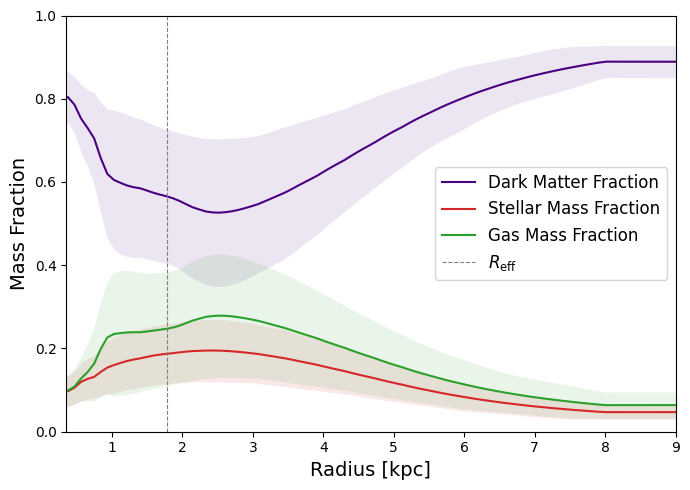

In [109]:
plt.figure(figsize=(7,5))

# --- Dark matter fraction ---
plt.plot(a_vals_kpc, fDM, color='indigo', label='Dark Matter Fraction')
plt.fill_between(a_vals_kpc, fDM_lo, fDM_hi, color='indigo', alpha=0.1, linewidth=0)

# --- Stellar fraction ---
plt.plot(a_vals_kpc, fS, color='tab:red', label='Stellar Mass Fraction')
plt.fill_between(a_vals_kpc, fS_lo, fS_hi, color='tab:red', alpha=0.1, linewidth=0)

# --- Gas fraction ---
plt.plot(a_vals_kpc, fG, color='tab:green', label='Gas Mass Fraction')
plt.fill_between(a_vals_kpc, fG_lo, fG_hi, color='tab:green', alpha=0.1, linewidth=0)

# Formatting
plt.xlabel("Radius [kpc]", fontsize=14)
plt.ylabel("Mass Fraction", fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.ylim(0,1)
plt.xlim(0.35,9)
plt.axvline(r_eff_kpc, color='gray', linestyle='--', linewidth=0.8, label=r'$R_{\rm eff}$')
plt.legend(fontsize=12)
plt.tight_layout()
# plt.savefig("mass_fractions_with_errors.pdf", dpi=300)
plt.show()
